# Multi-Agent Graph Similarity Validation Experiment
# Enhanced and Cleaned Version


## Objective
Test whether multiple agents independently build similar semantic graph structures when trained on ConceptNet data with injected false triples. This experiment validates the hypothesis of a universal theory of meaning that is self-reinforcing, rejects contradiction, and shows clear paths of reasoning.



## Experimental Design
- **Agents**: 5-10 independent agents
- **Data Source**: ConceptNet triples with randomly generated false triples injected
- **Training**: No filters, agents can ACCEPT/REJECT/REVIEW triples
- **Validation**: Measure graph similarity, structure, and false triple influence
- **Scalability**: Designed to scale from small experiments to full 3M dataset

## Key Hypothesis
If multiple agents build similar semantic structures without shared optimization or influence, this provides evidence for a fundamental theory of meaning.


# SECTION 1: IMPORTS AND CONFIGURATION

In [1]:

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import jaccard_score, adjusted_rand_score
from sklearn.cluster import KMeans
from scipy.spatial.distance import cosine, euclidean
from scipy.stats import pearsonr, spearmanr
import json
import pickle
import random
import time
from datetime import datetime, timedelta
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

print("Libraries imported successfully")
print(f"Experiment started at: {datetime.now()}")

# EXPERIMENTAL CONFIGURATION

CONFIG = {
    'experiment_name': 'multi_agent_validation_v1',
    'num_agents': 7,  # Start with 7 agents for comprehensive comparison
    'num_epochs': 5,  # Number of complete passes through the dataset
    'max_iterations': 150,  # Training iterations per epoch
    'false_triple_ratio': 0.1,  # 10% false triples injected
    'batch_size': 100,  # Triples per training batch
    'validation_threshold': 0.7,  # Agent validation confidence threshold
    'sample_size': 10_000,  # Initial sample from ConceptNet (scalable)
    'quality_threshold': 0.8,  # Minimum quality for triple acceptance
    'similarity_metrics': ['jaccard', 'weighted_jaccard', 'structural', 'semantic', 'path_based'],
    'save_checkpoints': True,
    'verbose': True,
    'epoch_verbose': True,  # Verbose reporting at epoch level
    'dataset_coverage_per_epoch': 0.8,  # Fraction of dataset to cover per epoch (for robustness)
    
    # === ADAPTIVE TRAINING CONFIGURATION ===
    'adaptive_training_mode': True,  # Enable intelligent training mode switching
    'coverage_based_training': True,  # Try coverage-based training first
    'target_coverage': 0.9,  # 90% coverage target for coverage-based training
    'coverage_timeout_minutes': 15,  # Max time to spend on coverage-based training
    'coverage_max_iterations': 500,  # Max iterations for coverage-based training
    'fallback_to_epochs': True,  # Fall back to epoch-based if coverage fails
    'coverage_check_frequency': 10,  # Check coverage every N iterations
    'coverage_progress_threshold': 0.01,  # Minimum progress required every 50 iterations
}

# File paths
DATA_PATH = Path(r'c:\Users\Erich Curtis\Desktop\All Python\Semantica-Full-Reasoning-Chatbot\Data\Input')
OUTPUT_PATH = Path(r'c:\Users\Erich Curtis\Desktop\All Python\Semantica-Full-Reasoning-Chatbot\Data\Output')

print("Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Libraries imported successfully
Experiment started at: 2025-05-27 12:35:56.163475
Configuration:
  experiment_name: multi_agent_validation_v1
  num_agents: 7
  num_epochs: 5
  max_iterations: 150
  false_triple_ratio: 0.1
  batch_size: 100
  validation_threshold: 0.7
  sample_size: 10000
  quality_threshold: 0.8
  similarity_metrics: ['jaccard', 'weighted_jaccard', 'structural', 'semantic', 'path_based']
  save_checkpoints: True
  verbose: True
  epoch_verbose: True
  dataset_coverage_per_epoch: 0.8
  adaptive_training_mode: True
  coverage_based_training: True
  target_coverage: 0.9
  coverage_timeout_minutes: 15
  coverage_max_iterations: 500
  fallback_to_epochs: True
  coverage_check_frequency: 10
  coverage_progress_threshold: 0.01



# SECTION 2: VALIDATION AGENT CLASS


In [2]:

class ValidationAgent:
    """Independent validation agent for semantic graph construction"""
    
    def __init__(self, agent_id, config):
        self.agent_id = agent_id
        self.config = config
        self.graph = nx.DiGraph()
        self.validation_history = []
        self.decision_log = {'ACCEPT': 0, 'REJECT': 0, 'REVIEW': 0}
        self.quality_scores = []
        self.training_metrics = {
            'iterations_completed': 0,
            'epochs_completed': 0,
            'triples_processed': 0,
            'false_triples_detected': 0,
            'accuracy': 0.0,
            'epoch_accuracies': [],  # Track accuracy across epochs
            'epoch_nodes': [],       # Track graph size across epochs
            'epoch_edges': []
        }
        
    def calculate_validation_score(self, triple, edge_weight=1.0):
        """Calculate validation score for a triple based on existing graph context"""
        subj, rel, obj = triple
        
        # Base score influenced by edge weight
        score = 0.4 + (edge_weight * 0.1)  # Higher weights get slightly higher base scores
        
        # Check for existing relationships
        if self.graph.has_node(subj) and self.graph.has_node(obj):
            # Check for direct connection
            if self.graph.has_edge(subj, obj):
                existing_rel = self.graph[subj][obj].get('relation', '')
                existing_weight = self.graph[subj][obj].get('weight', 1.0)
                
                if existing_rel == rel:
                    # Strengthen score based on weight consistency
                    weight_consistency = 1 - abs(existing_weight - edge_weight) / max(existing_weight, edge_weight)
                    score += 0.3 * weight_consistency
                else:
                    score -= 0.1  # Potential contradiction
            
            # Check for semantic consistency
            subj_neighbors = set(self.graph.neighbors(subj))
            obj_neighbors = set(self.graph.neighbors(obj))
            common_neighbors = len(subj_neighbors.intersection(obj_neighbors))
            
            if common_neighbors > 0:
                score += min(0.2, common_neighbors * 0.05)
        
        # Edge weight influence on validation
        if edge_weight >= 0.8:
            score += 0.1  # High confidence triples get bonus
        elif edge_weight <= 0.3:
            score -= 0.1  # Low confidence triples get penalty
        
        # Add noise for realism
        score += np.random.normal(0, 0.05)
        
        return max(0.0, min(1.0, score))
    
    def validate_triple(self, triple, edge_weight=1.0, is_false=False):
        """Validate a triple and make ACCEPT/REJECT/REVIEW decision"""
        score = self.calculate_validation_score(triple, edge_weight)
        
        # Decision logic adjusted for edge weights
        quality_threshold = self.config['quality_threshold']
        
        # Adjust thresholds based on edge weight
        if edge_weight >= 0.8:
            accept_threshold = quality_threshold - 0.1  # Lower threshold for high-weight triples
        elif edge_weight <= 0.3:
            accept_threshold = quality_threshold + 0.1  # Higher threshold for low-weight triples
        else:
            accept_threshold = quality_threshold
        
        if score >= accept_threshold:
            decision = 'ACCEPT'
        elif score <= 0.3:
            decision = 'REJECT'
        else:
            decision = 'REVIEW'
        
        # Track performance
        self.decision_log[decision] += 1
        correct = (decision == 'REJECT') if is_false else (decision == 'ACCEPT')
        
        self.validation_history.append({
            'triple': triple,
            'edge_weight': edge_weight,
            'score': score,
            'decision': decision,
            'is_false': is_false,
            'correct': correct,
            'epoch': self.training_metrics['epochs_completed'],
            'iteration': self.training_metrics['iterations_completed']
        })
        
        return decision, score
    
    def add_triple_to_graph(self, triple, edge_weight=1.0):
        """Add validated triple to the agent's graph"""
        subj, rel, obj = triple
        self.graph.add_edge(subj, obj, relation=rel, weight=edge_weight)
    
    def train_on_batch(self, triples_batch, edge_weights, false_flags):
        """Train agent on a batch of triples"""
        batch_accuracy = 0
        
        for triple, weight, is_false in zip(triples_batch, edge_weights, false_flags):
            decision, score = self.validate_triple(triple, weight, is_false)
            
            # Add to graph if accepted
            if decision == 'ACCEPT':
                self.add_triple_to_graph(triple, weight)
            
            # Track accuracy
            correct = (decision == 'REJECT') if is_false else (decision == 'ACCEPT')
            batch_accuracy += correct
            
            self.training_metrics['triples_processed'] += 1
            if is_false and decision == 'REJECT':
                self.training_metrics['false_triples_detected'] += 1
        
        self.training_metrics['accuracy'] = batch_accuracy / len(triples_batch)
        self.quality_scores.append(self.training_metrics['accuracy'])
    
    def complete_epoch(self):
        """Mark epoch completion and update epoch-level metrics"""
        self.training_metrics['epochs_completed'] += 1
        
        # Store epoch-level metrics
        stats = self.get_graph_stats()
        self.training_metrics['epoch_accuracies'].append(self.training_metrics['accuracy'])
        self.training_metrics['epoch_nodes'].append(stats['nodes'])
        self.training_metrics['epoch_edges'].append(stats['edges'])
        
    def get_graph_stats(self):
        """Get comprehensive graph statistics"""
        # Safely compute average clustering
        try:
            if self.graph.number_of_nodes() > 1 and self.graph.number_of_edges() > 0:
                avg_clustering = nx.average_clustering(self.graph.to_undirected())
            else:
                avg_clustering = 0.0
        except Exception:
            avg_clustering = 0.0
            
        return {
            'nodes': self.graph.number_of_nodes(),
            'edges': self.graph.number_of_edges(),
            'density': nx.density(self.graph),
            'avg_clustering': avg_clustering,
            'connected_components': nx.number_weakly_connected_components(self.graph),
            'avg_degree': np.mean([d for n, d in self.graph.degree()]) if self.graph.number_of_nodes() > 0 else 0
        }
    
    def get_epoch_summary(self):
        """Get summary of training across all epochs"""
        return {
            'agent_id': self.agent_id,
            'epochs_completed': self.training_metrics['epochs_completed'],
            'total_iterations': self.training_metrics['iterations_completed'],
            'total_triples_processed': self.training_metrics['triples_processed'],
            'epoch_accuracies': self.training_metrics['epoch_accuracies'],
            'epoch_nodes': self.training_metrics['epoch_nodes'],
            'epoch_edges': self.training_metrics['epoch_edges'],
            'final_accuracy': self.training_metrics['accuracy'],
            'false_triples_detected': self.training_metrics['false_triples_detected'],
            'decision_distribution': self.decision_log.copy(),
            'final_graph_stats': self.get_graph_stats()
        }

print("ValidationAgent class defined successfully")


ValidationAgent class defined successfully



# SECTION 3: FALSE TRIPLE GENERATOR CLASS


In [3]:

class FalseTripleGenerator:
    """Generate realistic false triples from real ConceptNet data"""
    
    def __init__(self, real_triples_df):
        self.real_triples = real_triples_df
        self.subjects = list(set(real_triples_df['subject'].values))
        self.relations = list(set(real_triples_df['relation'].values))
        self.objects = list(set(real_triples_df['object'].values))
        
        # Get edge weight distribution for realistic false weights
        if 'edge_weight' in real_triples_df.columns:
            self.weights = real_triples_df['edge_weight'].values
        else:
            self.weights = np.ones(len(real_triples_df))  # Default to 1.0
        
    def generate_false_triple(self):
        """Generate a false triple by mixing real components"""
        # Strategy 1: Random recombination (70%)
        if np.random.random() < 0.7:
            subj = np.random.choice(self.subjects)
            rel = np.random.choice(self.relations)
            obj = np.random.choice(self.objects)
            
            # Ensure it's not a real triple
            attempts = 0
            while self._is_real_triple(subj, rel, obj) and attempts < 10:
                obj = np.random.choice(self.objects)
                attempts += 1
                
        # Strategy 2: Semantic contradiction (20%)
        elif np.random.random() < 0.9:
            # Take a real triple and swap subject/object
            real_triple = self.real_triples.sample(1).iloc[0]
            subj = real_triple['object']
            rel = real_triple['relation']
            obj = real_triple['subject']
            
        # Strategy 3: Nonsensical relations (10%)
        else:
            real_triple = self.real_triples.sample(1).iloc[0]
            subj = real_triple['subject']
            rel = np.random.choice(self.relations)
            obj = real_triple['object']
            
            # Ensure different relation
            attempts = 0
            while rel == real_triple['relation'] and attempts < 10:
                rel = np.random.choice(self.relations)
                attempts += 1
        
        # Generate a false but realistic edge weight
        # False triples tend to have lower weights in practice
        false_weight = np.random.choice(self.weights) * np.random.uniform(0.3, 0.8)
        false_weight = max(0.1, min(1.0, false_weight))  # Clamp to valid range
                
        return (subj, rel, obj), false_weight
    
    def _is_real_triple(self, subj, rel, obj):
        """Check if a triple exists in real data"""
        return len(self.real_triples[
            (self.real_triples['subject'] == subj) &
            (self.real_triples['relation'] == rel) &
            (self.real_triples['object'] == obj)
        ]) > 0
    
    def inject_false_triples(self, real_batch, real_weights, false_ratio=0.15):
        """Inject false triples into a batch of real triples"""
        num_false = int(len(real_batch) * false_ratio)
        false_triples = []
        false_weights = []
        false_flags = [False] * len(real_batch)
        
        # Generate false triples
        for _ in range(num_false):
            false_triple, false_weight = self.generate_false_triple()
            false_triples.append(false_triple)
            false_weights.append(false_weight)
        
        # Combine and shuffle
        all_triples = list(real_batch) + false_triples
        all_weights = list(real_weights) + false_weights
        all_flags = false_flags + [True] * num_false
        
        # Shuffle together
        combined = list(zip(all_triples, all_weights, all_flags))
        np.random.shuffle(combined)
        triples, weights, flags = zip(*combined)
        
        return list(triples), list(weights), list(flags)

print("FalseTripleGenerator class defined successfully")


FalseTripleGenerator class defined successfully



# SECTION 4: DATA LOADING AND PREPROCESSING


In [5]:

print("Loading ConceptNet data...")

try:
    # Try loading preprocessed parquet file first
    conceptnet_file = DATA_PATH / 'conceptnet_en_processed_for_graph.parquet.gzip'
    if conceptnet_file.exists():
        df_raw = pd.read_parquet(conceptnet_file)
        print(f"Loaded preprocessed data: {len(df_raw)} triples")
        
        # Map columns to expected format: relation_type, start_concept, end_concept, edge_weight
        if 'relation_type' in df_raw.columns and 'start_concept' in df_raw.columns:
            df = df_raw.rename(columns={
                'start_concept': 'subject',
                'relation_type': 'relation', 
                'end_concept': 'object'
            }).copy()
            print("Column mapping applied: start_concept -> subject, relation_type -> relation, end_concept -> object")
        else:
            # Fallback column mapping if different structure
            df = df_raw.copy()
            if df.shape[1] >= 3:
                df.columns = ['subject', 'relation', 'object'] + list(df.columns[3:])
    else:
        # Fallback to CSV
        conceptnet_file = DATA_PATH / 'conceptnet_en_triples.csv'
        df_raw = pd.read_csv(conceptnet_file)
        print(f"Loaded CSV data: {len(df_raw)} triples")
        
        # Map columns to expected format
        if 'relation_type' in df_raw.columns and 'start_concept' in df_raw.columns:
            df = df_raw.rename(columns={
                'start_concept': 'subject',
                'relation_type': 'relation',
                'end_concept': 'object'
            }).copy()
        else:
            df = df_raw.copy()
            if 'subject' not in df.columns:
                # Assume first three columns are subject, relation, object
                df.columns = ['subject', 'relation', 'object'] + list(df.columns[3:])
        
except Exception as e:
    print(f"Error loading data: {e}")
    # Create sample data for testing using realistic ConceptNet relations
    print("Creating sample data for testing...")
    df = pd.DataFrame({
        'subject': ['cat', 'dog', 'bird', 'fish', 'tree', 'happy', 'run', 'blue'] * 625,
        'relation': ['IsA', 'HasProperty', 'RelatedTo', 'CapableOf', 'AtLocation', 'FormOf', 'DerivedFrom', 'Synonym'] * 625,
        'object': ['animal', 'pet', 'living_thing', 'water', 'forest', 'emotion', 'move', 'color'] * 625,
        'edge_weight': np.random.choice([0.5, 0.7, 1.0], size=5000, p=[0.1, 0.2, 0.7])  # Realistic weight distribution
    })

# Sample data for experiment

def ensure_all_nodes_connected(df, sample_size):
    """
    Ensure every subject and object in the sample is connected to at least one other node.
    """
    # Start with a random sample
    if len(df) <= sample_size:
        sample = df.copy()
    else:
        sample = df.sample(n=sample_size, random_state=42)

    # Build undirected graph for connectivity check
    G = nx.from_pandas_edgelist(sample, 'subject', 'object', create_using=nx.Graph())

    # Find isolated nodes (degree 0)
    all_nodes = set(sample['subject']).union(set(sample['object']))
    node_degrees = dict(G.degree(all_nodes))
    isolated_nodes = [node for node, deg in node_degrees.items() if deg == 0]

    # For each isolated node, try to add a triple from df that connects it to the sample
    for node in isolated_nodes:
        # Find triples in df (not already in sample) where node is subject or object
        candidates = df[
            ((df['subject'] == node) | (df['object'] == node)) &
            ~df.index.isin(sample.index)
        ]
        # Prefer triples that connect to an already-included node
        candidates = candidates[
            (candidates['subject'].isin(all_nodes)) | (candidates['object'].isin(all_nodes))
        ]
        if not candidates.empty:
            # Add the first candidate triple
            sample = pd.concat([sample, candidates.iloc[[0]]], ignore_index=True)
            # Update graph and node set
            G.add_edge(candidates.iloc[0]['subject'], candidates.iloc[0]['object'])
            all_nodes.add(candidates.iloc[0]['subject'])
            all_nodes.add(candidates.iloc[0]['object'])

    # Remove any remaining isolated nodes (if no connecting triple exists)
    G = nx.from_pandas_edgelist(sample, 'subject', 'object', create_using=nx.Graph())
    node_degrees = dict(G.degree(all_nodes))
    still_isolated = [node for node, deg in node_degrees.items() if deg == 0]
    if still_isolated:
        sample = sample[
            ~sample['subject'].isin(still_isolated) &
            ~sample['object'].isin(still_isolated)
        ].reset_index(drop=True)

    # If sample is now larger than sample_size, downsample
    if len(sample) > sample_size:
        sample = sample.sample(n=sample_size, random_state=42).reset_index(drop=True)

    return sample

if len(df) > CONFIG['sample_size']:
    df_sample = ensure_all_nodes_connected(df, CONFIG['sample_size'])
else:
    df_sample = df.copy()

print(f"Using {len(df_sample)} triples for experiment")
print(f"Unique subjects: {df_sample['subject'].nunique()}")
print(f"Unique relations: {df_sample['relation'].nunique()}")
print(f"Unique objects: {df_sample['object'].nunique()}")

# Show edge weight distribution if available
if 'edge_weight' in df_sample.columns:
    print(f"Edge weight distribution:")
    print(f"  Mean: {df_sample['edge_weight'].mean():.3f}")
    print(f"  Range: [{df_sample['edge_weight'].min():.1f}, {df_sample['edge_weight'].max():.1f}]")
    weight_counts = df_sample['edge_weight'].value_counts().head()
    print(f"  Top weights: {dict(weight_counts)}")

# Create false triple generator
false_generator = FalseTripleGenerator(df_sample)
print("False triple generator initialized")


Loading ConceptNet data...
Loaded preprocessed data: 1655522 triples
Column mapping applied: start_concept -> subject, relation_type -> relation, end_concept -> object
Using 10000 triples for experiment
Unique subjects: 5139
Unique relations: 45
Unique objects: 8683
Edge weight distribution:
  Mean: 0.936
  Range: [0.1, 8.9]
  Top weights: {1.0: np.int64(7864), 0.5: np.int64(542), 0.25: np.int64(290), 2.0: np.int64(247), 2.828: np.int64(42)}
False triple generator initialized
Loaded preprocessed data: 1655522 triples
Column mapping applied: start_concept -> subject, relation_type -> relation, end_concept -> object
Using 10000 triples for experiment
Unique subjects: 5139
Unique relations: 45
Unique objects: 8683
Edge weight distribution:
  Mean: 0.936
  Range: [0.1, 8.9]
  Top weights: {1.0: np.int64(7864), 0.5: np.int64(542), 0.25: np.int64(290), 2.0: np.int64(247), 2.828: np.int64(42)}
False triple generator initialized



# SECTION 5: AGENT INITIALIZATION


In [6]:

print(f"\nInitializing {CONFIG['num_agents']} validation agents...")

agents = []
for i in range(CONFIG['num_agents']):
    # Assign a unique random seed to each agent
    agent_config = CONFIG.copy()
    agent_config['agent_seed'] = int(time.time() * 1000) % (2**32) + i * 1000
    agents.append(ValidationAgent(f"Agent_{i+1}", agent_config))
    print(f"  Agent {i+1} initialized with seed {agent_config['agent_seed']}")

print(f"\nAll {len(agents)} agents ready for training")
print("Agent configurations:")
for agent in agents:
    print(f"  {agent.agent_id}: Graph nodes={agent.graph.number_of_nodes()}, edges={agent.graph.number_of_edges()}")

# Calculate all unique subjects and objects in the dataset
all_subjects = set(df_sample['subject'].unique())
all_objects = set(df_sample['object'].unique())
all_entities = all_subjects | all_objects
print(f"\nTotal unique subjects and objects: {len(all_entities):,}")



Initializing 7 validation agents...
  Agent 1 initialized with seed 315697906
  Agent 2 initialized with seed 315698906
  Agent 3 initialized with seed 315699906
  Agent 4 initialized with seed 315700906
  Agent 5 initialized with seed 315701906
  Agent 6 initialized with seed 315702906
  Agent 7 initialized with seed 315703907

All 7 agents ready for training
Agent configurations:
  Agent_1: Graph nodes=0, edges=0
  Agent_2: Graph nodes=0, edges=0
  Agent_3: Graph nodes=0, edges=0
  Agent_4: Graph nodes=0, edges=0
  Agent_5: Graph nodes=0, edges=0
  Agent_6: Graph nodes=0, edges=0
  Agent_7: Graph nodes=0, edges=0

Total unique subjects and objects: 13,165



# SECTION 6: ADAPTIVE TRAINING SYSTEM


In [7]:

def get_entity_coverage(agent_graph, all_entities):
    """Calculate entity coverage for an agent"""
    agent_nodes = set(agent_graph.nodes())
    return len(agent_nodes & all_entities) / len(all_entities)

def adaptive_training_system(agents, df_sample, false_generator, all_entities, config):
    """
    Intelligent training system that tries coverage-based training first,
    then falls back to epoch-based training if needed.
    """
    print("\n" + "="*80)
    print("🚀 STARTING ADAPTIVE MULTI-AGENT TRAINING SYSTEM")
    print("="*80)
    
    training_history = []
    training_start_time = time.time()
    training_mode = "DETERMINING"
    
    # Configuration
    target_coverage = config['target_coverage']
    timeout_minutes = config['coverage_timeout_minutes']
    max_coverage_iterations = config['coverage_max_iterations']
    check_freq = config['coverage_check_frequency']
    progress_threshold = config['coverage_progress_threshold']
    
    print(f"🎯 Target Coverage: {target_coverage*100:.1f}%")
    print(f"⏰ Coverage Timeout: {timeout_minutes} minutes")
    print(f"🔄 Max Coverage Iterations: {max_coverage_iterations}")
    print(f"📊 Adaptive Mode: {'ENABLED' if config['adaptive_training_mode'] else 'DISABLED'}")
    
    # === PHASE 1: TRY COVERAGE-BASED TRAINING ===
    if config['adaptive_training_mode'] and config['coverage_based_training']:
        print(f"\n🎯 PHASE 1: ATTEMPTING COVERAGE-BASED CONTINUOUS TRAINING")
        print("-" * 60)
        
        coverage_reached = [False] * len(agents)
        coverage_start_time = time.time()
        timeout_time = coverage_start_time + (timeout_minutes * 60)
        
        # Track coverage progress for stagnation detection
        coverage_history = {agent.agent_id: [] for agent in agents}
        last_progress_check = 0
        
        for iteration in range(max_coverage_iterations):
            # Check timeout
            if time.time() > timeout_time:
                print(f"⏰ TIMEOUT: Coverage-based training exceeded {timeout_minutes} minutes")
                break
            
            print(f"\n📍 Coverage Iteration {iteration + 1}/{max_coverage_iterations}")
            print("-" * 40)
            
            # Train each agent
            iteration_results = []
            for agent in agents:
                # Unique seed for reproducibility
                np.random.seed(agent.config.get('agent_seed', 42) + iteration * 1000)
                random.seed(agent.config.get('agent_seed', 42) + iteration * 1000)
                
                # Sample batch
                batch_data = df_sample.sample(n=min(config['batch_size'], len(df_sample)), replace=True)
                real_triples = [(row['subject'], row['relation'], row['object']) 
                               for _, row in batch_data.iterrows()]
                real_weights = batch_data.get('edge_weight', pd.Series([1.0] * len(batch_data))).values
                
                # Inject false triples
                mixed_triples, mixed_weights, truth_flags = false_generator.inject_false_triples(
                    real_triples, real_weights, config['false_triple_ratio']
                )
                
                # Train agent
                agent.train_on_batch(mixed_triples, mixed_weights, truth_flags)
                agent.training_metrics['iterations_completed'] = iteration + 1
                stats = agent.get_graph_stats()
                accuracy = agent.training_metrics['accuracy']
                
                iteration_results.append({
                    'agent_id': agent.agent_id,
                    'mode': 'COVERAGE_BASED',
                    'iteration': iteration + 1,
                    'accuracy': accuracy,
                    'graph_nodes': stats['nodes'],
                    'graph_edges': stats['edges'],
                    'graph_density': stats['density'],
                    'decisions': agent.decision_log.copy()
                })
                
                if config['verbose'] and iteration % 5 == 0:
                    print(f"    {agent.agent_id}: Acc={accuracy:.3f}, Nodes={stats['nodes']}, Edges={stats['edges']}")
            
            # Check coverage every N iterations
            if (iteration + 1) % check_freq == 0:
                print(f"\n📊 COVERAGE CHECK (Iteration {iteration + 1}):")
                current_coverages = []
                
                for idx, agent in enumerate(agents):
                    coverage = get_entity_coverage(agent.graph, all_entities)
                    coverage_history[agent.agent_id].append(coverage)
                    current_coverages.append(coverage)
                    
                    if not coverage_reached[idx] and coverage >= target_coverage:
                        print(f"🎉 {agent.agent_id} reached {coverage*100:.1f}% coverage!")
                        coverage_reached[idx] = True
                    else:
                        print(f"   {agent.agent_id}: {coverage*100:.1f}% coverage")
                
                # Check if all agents reached target
                if all(coverage_reached):
                    elapsed_time = time.time() - coverage_start_time
                    print(f"\n🏆 SUCCESS! All agents reached {target_coverage*100:.1f}% coverage in {elapsed_time/60:.1f} minutes")
                    training_mode = "COVERAGE_SUCCESS"
                    training_history.extend(iteration_results)
                    break
                
                # Check for stagnation (no progress in coverage)
                if iteration > 50 and (iteration - last_progress_check) >= 50:
                    progress_detected = False
                    for agent_id, hist in coverage_history.items():
                        if len(hist) >= 2:
                            recent_progress = hist[-1] - hist[-6] if len(hist) >= 6 else hist[-1] - hist[0]
                            if recent_progress >= progress_threshold:
                                progress_detected = True
                                break
                    
                    if not progress_detected:
                        avg_coverage = np.mean(current_coverages)
                        print(f"⚠️  STAGNATION: No significant progress detected (avg coverage: {avg_coverage*100:.1f}%)")
                        if avg_coverage < 0.5:  # Very low coverage
                            print("💔 Coverage-based training appears ineffective - will fallback to epochs")
                            break
                    
                    last_progress_check = iteration
            
            training_history.extend(iteration_results)
        
        # Assess coverage-based training results
        if not all(coverage_reached):
            final_coverages = [get_entity_coverage(agent.graph, all_entities) for agent in agents]
            avg_coverage = np.mean(final_coverages)
            elapsed_time = time.time() - coverage_start_time
            
            print(f"\n📊 COVERAGE-BASED TRAINING RESULTS:")
            print(f"   Average Coverage: {avg_coverage*100:.1f}%")
            print(f"   Agents at Target: {sum(coverage_reached)}/{len(agents)}")
            print(f"   Time Elapsed: {elapsed_time/60:.1f} minutes")
            
            if not config['fallback_to_epochs']:
                print("🛑 Fallback disabled - stopping training")
                training_mode = "COVERAGE_INCOMPLETE"
            else:
                print("🔄 Proceeding to epoch-based training fallback")
                training_mode = "FALLBACK_TO_EPOCHS"
        else:
            training_mode = "COVERAGE_SUCCESS"
    else:
        print(f"⏩ SKIPPING coverage-based training (disabled in config)")
        training_mode = "EPOCH_BASED_ONLY"
    
    # === PHASE 2: EPOCH-BASED TRAINING (FALLBACK OR PRIMARY) ===
    if training_mode in ["FALLBACK_TO_EPOCHS", "EPOCH_BASED_ONLY"]:
        print(f"\n🏛️ PHASE 2: EPOCH-BASED TRAINING")
        print("-" * 60)
        
        if training_mode == "FALLBACK_TO_EPOCHS":
            print("🔄 Coverage-based training incomplete - using epoch-based as fallback")
        else:
            print("📚 Using traditional epoch-based training as primary method")
        
        # Traditional epoch-based training
        max_epochs = config.get('num_epochs', 5)
        max_iterations = config.get('max_iterations', 150)
        batch_size = config['batch_size']
        
        for epoch in range(max_epochs):
            print(f"\n📖 EPOCH {epoch+1}/{max_epochs}")
            print("=" * 30)
            
            for iteration in range(max_iterations):
                if config['epoch_verbose'] and iteration % 20 == 0:
                    print(f"   Iteration {iteration + 1}/{max_iterations}")
                
                # Each agent trains independently
                iteration_results = []
                for agent in agents:
                    # Unique seed
                    np.random.seed(agent.config.get('agent_seed', 42) + epoch * 1000 + iteration)
                    random.seed(agent.config.get('agent_seed', 42) + epoch * 1000 + iteration)
                    
                    # Sample and train
                    batch_data = df_sample.sample(n=min(batch_size, len(df_sample)), replace=True)
                    real_triples = [(row['subject'], row['relation'], row['object']) 
                                   for _, row in batch_data.iterrows()]
                    real_weights = batch_data.get('edge_weight', pd.Series([1.0] * len(batch_data))).values
                    
                    mixed_triples, mixed_weights, truth_flags = false_generator.inject_false_triples(
                        real_triples, real_weights, config['false_triple_ratio']
                    )
                    
                    agent.train_on_batch(mixed_triples, mixed_weights, truth_flags)
                    agent.training_metrics['iterations_completed'] = iteration + 1
                    stats = agent.get_graph_stats()
                    accuracy = agent.training_metrics['accuracy']
                    
                    iteration_results.append({
                        'agent_id': agent.agent_id,
                        'mode': 'EPOCH_BASED',
                        'epoch': epoch + 1,
                        'iteration': iteration + 1,
                        'accuracy': accuracy,
                        'graph_nodes': stats['nodes'],
                        'graph_edges': stats['edges'],
                        'graph_density': stats['density'],
                        'decisions': agent.decision_log.copy()
                    })
                
                training_history.extend(iteration_results)
                
                # Verbose output
                if config['verbose'] and iteration % 30 == 0:
                    for agent in agents:
                        stats = agent.get_graph_stats()
                        accuracy = agent.training_metrics['accuracy']
                        print(f"      {agent.agent_id}: Acc={accuracy:.3f}, Nodes={stats['nodes']}, Edges={stats['edges']}")
            
            # Complete epoch for all agents
            for agent in agents:
                agent.complete_epoch()
        
        training_mode = "EPOCH_BASED_COMPLETE"
    
    # === TRAINING SUMMARY ===
    total_time = time.time() - training_start_time
    print(f"\n🎉 ADAPTIVE TRAINING COMPLETE!")
    print("=" * 50)
    print(f"🎯 Final Training Mode: {training_mode}")
    print(f"⏱️  Total Training Time: {total_time/60:.1f} minutes")
    print(f"📊 Total Training Records: {len(training_history)}")
    
    # Final coverage check
    print(f"\n📈 FINAL COVERAGE ANALYSIS:")
    for agent in agents:
        coverage = get_entity_coverage(agent.graph, all_entities)
        stats = agent.get_graph_stats()
        print(f"   {agent.agent_id}: {coverage*100:.1f}% coverage, {stats['nodes']} nodes, {stats['edges']} edges")
    
    return training_history, training_mode



# SECTION 7: EXECUTE TRAINING


In [9]:

print("🎯 Initializing Adaptive Training System...")
required_coverage = CONFIG['target_coverage']  # Use config value

training_history, final_training_mode = adaptive_training_system(
    agents=agents,
    df_sample=df_sample, 
    false_generator=false_generator,
    all_entities=all_entities,
    config=CONFIG
)

🎯 Initializing Adaptive Training System...

🚀 STARTING ADAPTIVE MULTI-AGENT TRAINING SYSTEM
🎯 Target Coverage: 90.0%
⏰ Coverage Timeout: 15 minutes
🔄 Max Coverage Iterations: 500
📊 Adaptive Mode: ENABLED

🎯 PHASE 1: ATTEMPTING COVERAGE-BASED CONTINUOUS TRAINING
------------------------------------------------------------

📍 Coverage Iteration 1/500
----------------------------------------
    Agent_1: Acc=0.055, Nodes=202, Edges=124
    Agent_2: Acc=0.000, Nodes=196, Edges=120
    Agent_3: Acc=0.055, Nodes=196, Edges=120
    Agent_4: Acc=0.045, Nodes=203, Edges=125
    Agent_5: Acc=0.055, Nodes=205, Edges=127
    Agent_6: Acc=0.045, Nodes=206, Edges=128
    Agent_7: Acc=0.045, Nodes=200, Edges=119

📍 Coverage Iteration 2/500
----------------------------------------
    Agent_6: Acc=0.045, Nodes=206, Edges=128
    Agent_7: Acc=0.045, Nodes=200, Edges=119

📍 Coverage Iteration 2/500
----------------------------------------

📍 Coverage Iteration 3/500
-------------------------------------

# SECTION 8: SIMILARITY ANALYSIS FUNCTIONS

In [10]:

def calculate_jaccard_similarity(graph1, graph2):
    """Calculate Jaccard similarity between two graphs"""
    edges1 = set(graph1.edges())
    edges2 = set(graph2.edges())
    
    intersection = len(edges1.intersection(edges2))
    union = len(edges1.union(edges2))
    
    return intersection / union if union > 0 else 0

def calculate_weighted_jaccard_similarity(graph1, graph2):
    """Calculate weighted Jaccard similarity considering edge weights"""
    # Get all edges from both graphs
    all_edges = set(graph1.edges()) | set(graph2.edges())
    
    if not all_edges:
        return 0
    
    intersection_weight = 0
    union_weight = 0
    
    for edge in all_edges:
        weight1 = graph1[edge[0]][edge[1]].get('weight', 0) if graph1.has_edge(*edge) else 0
        weight2 = graph2[edge[0]][edge[1]].get('weight', 0) if graph2.has_edge(*edge) else 0
        
        intersection_weight += min(weight1, weight2)
        union_weight += max(weight1, weight2)
    
    return intersection_weight / union_weight if union_weight > 0 else 0

def calculate_node_overlap(graph1, graph2):
    """Calculate node overlap between two graphs"""
    nodes1 = set(graph1.nodes())
    nodes2 = set(graph2.nodes())
    
    intersection = len(nodes1.intersection(nodes2))
    union = len(nodes1.union(nodes2))
    
    return intersection / union if union > 0 else 0

def calculate_structural_similarity(graph1, graph2):
    """Calculate structural similarity based on graph properties"""
    stats1 = {
        'nodes': graph1.number_of_nodes(),
        'edges': graph1.number_of_edges(),
        'density': nx.density(graph1),
        'avg_clustering': nx.average_clustering(graph1.to_undirected()) if graph1.number_of_nodes() > 0 else 0
    }
    
    stats2 = {
        'nodes': graph2.number_of_nodes(),
        'edges': graph2.number_of_edges(),
        'density': nx.density(graph2),
        'avg_clustering': nx.average_clustering(graph2.to_undirected()) if graph2.number_of_nodes() > 0 else 0
    }
    
    # Calculate normalized differences
    similarities = []
    for key in stats1.keys():
        if stats1[key] + stats2[key] > 0:
            sim = 1 - abs(stats1[key] - stats2[key]) / (stats1[key] + stats2[key])
            similarities.append(sim)
    
    return np.mean(similarities) if similarities else 0

def calculate_semantic_similarity(graph1, graph2):
    """Calculate semantic similarity based on relation types"""
    # Get relation distributions
    relations1 = [data['relation'] for _, _, data in graph1.edges(data=True) if 'relation' in data]
    relations2 = [data['relation'] for _, _, data in graph2.edges(data=True) if 'relation' in data]
    
    if not relations1 or not relations2:
        return 0
    
    # Create relation frequency vectors
    all_relations = list(set(relations1 + relations2))
    
    freq1 = np.array([relations1.count(rel) for rel in all_relations])
    freq2 = np.array([relations2.count(rel) for rel in all_relations])
    
    # Normalize
    freq1 = freq1 / np.sum(freq1) if np.sum(freq1) > 0 else freq1
    freq2 = freq2 / np.sum(freq2) if np.sum(freq2) > 0 else freq2
    
    # Calculate cosine similarity
    dot_product = np.dot(freq1, freq2)
    norms = np.linalg.norm(freq1) * np.linalg.norm(freq2)
    
    return dot_product / norms if norms > 0 else 0

def calculate_path_similarity(graph1, graph2, sample_size=100):
    """Calculate similarity based on shortest paths between common nodes"""
    common_nodes = list(set(graph1.nodes()).intersection(set(graph2.nodes())))
    
    if len(common_nodes) < 2:
        return 0
    
    # Sample node pairs
    sample_pairs = [(common_nodes[i], common_nodes[j]) 
                   for i in range(min(sample_size, len(common_nodes))) 
                   for j in range(i+1, min(sample_size, len(common_nodes)))]
    
    path_similarities = []
    
    for source, target in sample_pairs[:sample_size]:
        try:
            path1 = nx.shortest_path_length(graph1, source, target)
            path2 = nx.shortest_path_length(graph2, source, target)
            
            # Similarity based on path length difference
            max_path = max(path1, path2)
            similarity = 1 - abs(path1 - path2) / max_path if max_path > 0 else 1
            path_similarities.append(similarity)
            
        except nx.NetworkXNoPath:
            # One or both graphs don't have a path
            path_similarities.append(0)
    
    return np.mean(path_similarities) if path_similarities else 0

print("Graph similarity functions defined successfully")

Graph similarity functions defined successfully


# SECTION 9: CALCULATE SIMILARITY MATRICES

In [11]:

print("\n" + "="*60)
print("CALCULATING AGENT SIMILARITY MATRIX")
print("="*60)

num_agents = len(agents)
similarity_results = {
    'jaccard': np.zeros((num_agents, num_agents)),
    'weighted_jaccard': np.zeros((num_agents, num_agents)),
    'node_overlap': np.zeros((num_agents, num_agents)),
    'structural': np.zeros((num_agents, num_agents)),
    'semantic': np.zeros((num_agents, num_agents)),
    'path_based': np.zeros((num_agents, num_agents))
}

print(f"Comparing {num_agents} agents pairwise...")

for i in range(num_agents):
    for j in range(num_agents):
        if i == j:
            # Self-similarity is 1.0
            for metric in similarity_results.keys():
                similarity_results[metric][i][j] = 1.0
        else:
            graph1 = agents[i].graph
            graph2 = agents[j].graph
            
            # Calculate all similarity metrics
            similarity_results['jaccard'][i][j] = calculate_jaccard_similarity(graph1, graph2)
            similarity_results['weighted_jaccard'][i][j] = calculate_weighted_jaccard_similarity(graph1, graph2)
            similarity_results['node_overlap'][i][j] = calculate_node_overlap(graph1, graph2)
            similarity_results['structural'][i][j] = calculate_structural_similarity(graph1, graph2)
            similarity_results['semantic'][i][j] = calculate_semantic_similarity(graph1, graph2)
            similarity_results['path_based'][i][j] = calculate_path_similarity(graph1, graph2)

print("Similarity calculations completed!")

# Calculate summary statistics
summary_stats = {}
for metric, matrix in similarity_results.items():
    # Get upper triangle (excluding diagonal)
    upper_triangle = matrix[np.triu_indices_from(matrix, k=1)]
    
    summary_stats[metric] = {
        'mean': np.mean(upper_triangle),
        'std': np.std(upper_triangle),
        'min': np.min(upper_triangle),
        'max': np.max(upper_triangle),
        'median': np.median(upper_triangle)
    }

print("\nSimilarity Summary Statistics:")
for metric, stats in summary_stats.items():
    print(f"\n{metric.upper()} Similarity:")
    print(f"  Mean: {stats['mean']:.4f}")
    print(f"  Std:  {stats['std']:.4f}")
    print(f"  Range: [{stats['min']:.4f}, {stats['max']:.4f}]")


CALCULATING AGENT SIMILARITY MATRIX
Comparing 7 agents pairwise...
Similarity calculations completed!

Similarity Summary Statistics:

JACCARD Similarity:
  Mean: 0.5792
  Std:  0.2050
  Range: [0.2244, 0.8472]

WEIGHTED_JACCARD Similarity:
  Mean: 0.6400
  Std:  0.1816
  Range: [0.3201, 0.8735]

NODE_OVERLAP Similarity:
  Mean: 0.5947
  Std:  0.1969
  Range: [0.2523, 0.8557]

STRUCTURAL Similarity:
  Mean: 0.9920
  Std:  0.0051
  Range: [0.9788, 0.9995]

SEMANTIC Similarity:
  Mean: 0.9997
  Std:  0.0001
  Range: [0.9994, 0.9999]

PATH_BASED Similarity:
  Mean: 0.0000
  Std:  0.0000
  Range: [0.0000, 0.0000]
Similarity calculations completed!

Similarity Summary Statistics:

JACCARD Similarity:
  Mean: 0.5792
  Std:  0.2050
  Range: [0.2244, 0.8472]

WEIGHTED_JACCARD Similarity:
  Mean: 0.6400
  Std:  0.1816
  Range: [0.3201, 0.8735]

NODE_OVERLAP Similarity:
  Mean: 0.5947
  Std:  0.1969
  Range: [0.2523, 0.8557]

STRUCTURAL Similarity:
  Mean: 0.9920
  Std:  0.0051
  Range: [0.9788

# SECTION 10: AGENT PERFORMANCE ANALYSIS

In [12]:

print("\n" + "="*60)
print("AGENT PERFORMANCE ANALYSIS")
print("="*60)

# Collect final agent statistics
agent_performance = []

for agent in agents:
    stats = agent.get_graph_stats()
    metrics = agent.training_metrics
    
    # Calculate additional metrics
    total_decisions = sum(agent.decision_log.values())
    accept_rate = agent.decision_log['ACCEPT'] / total_decisions if total_decisions > 0 else 0
    reject_rate = agent.decision_log['REJECT'] / total_decisions if total_decisions > 0 else 0
    review_rate = agent.decision_log['REVIEW'] / total_decisions if total_decisions > 0 else 0
    
    # False positive rate (accepting false triples)
    false_acceptances = sum(1 for v in agent.validation_history 
                           if v['is_false'] and v['decision'] == 'ACCEPT')
    false_positives = len([v for v in agent.validation_history if v['is_false']])
    false_positive_rate = false_acceptances / false_positives if false_positives > 0 else 0
    
    performance = {
        'agent_id': agent.agent_id,
        'final_accuracy': metrics['accuracy'],
        'graph_nodes': stats['nodes'],
        'graph_edges': stats['edges'],
        'graph_density': stats['density'],
        'avg_clustering': stats['avg_clustering'],
        'connected_components': stats['connected_components'],
        'triples_processed': metrics['triples_processed'],
        'false_triples_detected': metrics['false_triples_detected'],
        'accept_rate': accept_rate,
        'reject_rate': reject_rate,
        'review_rate': review_rate,
        'false_positive_rate': false_positive_rate,
        'avg_degree': stats['avg_degree']
    }
    
    agent_performance.append(performance)

# Convert to DataFrame for analysis
perf_df = pd.DataFrame(agent_performance)

print("\nAgent Performance Summary:")
print(perf_df[['agent_id', 'final_accuracy', 'graph_nodes', 'graph_edges', 
               'accept_rate', 'reject_rate', 'false_positive_rate']].to_string(index=False))

# Calculate performance statistics
print("\n\nPerformance Statistics Across All Agents:")
print(f"Average Accuracy: {perf_df['final_accuracy'].mean():.4f} ± {perf_df['final_accuracy'].std():.4f}")
print(f"Average Graph Size: {perf_df['graph_nodes'].mean():.1f} nodes, {perf_df['graph_edges'].mean():.1f} edges")
print(f"Average Accept Rate: {perf_df['accept_rate'].mean():.4f} ± {perf_df['accept_rate'].std():.4f}")
print(f"Average False Positive Rate: {perf_df['false_positive_rate'].mean():.4f} ± {perf_df['false_positive_rate'].std():.4f}")


AGENT PERFORMANCE ANALYSIS

Agent Performance Summary:
agent_id  final_accuracy  graph_nodes  graph_edges  accept_rate  reject_rate  false_positive_rate
 Agent_1        0.218182         3277         2345     0.138508     0.036878             0.000727
 Agent_2        0.200000         3229         2308     0.137891     0.036731             0.000646
 Agent_3        0.245455         3214         2302     0.137657     0.036577             0.000485
 Agent_4        0.354545         3211         2299     0.137848     0.036364             0.000485
 Agent_5        0.263636         3174         2272     0.137811     0.036606             0.000323
 Agent_6        0.227273         3141         2238     0.135026     0.036525             0.000323
 Agent_7        0.236364         3193         2281     0.134732     0.037106             0.000647


Performance Statistics Across All Agents:
Average Accuracy: 0.2494 ± 0.0506
Average Graph Size: 3205.6 nodes, 2292.1 edges
Average Accept Rate: 0.1371 ± 0.001

# SECTION 11: STATISTICAL ANALYSIS

In [13]:

print("\n" + "="*60)
print("STATISTICAL ANALYSIS & HYPOTHESIS TESTING")
print("="*60)

# 1. Test for Universal Semantic Structure
print("\n1. TESTING FOR UNIVERSAL SEMANTIC STRUCTURE")
print("-" * 50)

# Calculate overall similarity scores
overall_similarities = []
for metric, matrix in similarity_results.items():
    upper_triangle = matrix[np.triu_indices_from(matrix, k=1)]
    mean_sim = np.mean(upper_triangle)
    overall_similarities.append(mean_sim)
    print(f"{metric.upper()} - Mean similarity: {mean_sim:.4f}")

# Overall consistency score
consistency_score = np.mean(overall_similarities)
print(f"\nOVERALL CONSISTENCY SCORE: {consistency_score:.4f}")

# Interpretation
if consistency_score > 0.7:
    interpretation = "STRONG evidence for universal semantic structure"
elif consistency_score > 0.5:
    interpretation = "MODERATE evidence for universal semantic structure"
else:
    interpretation = "WEAK evidence for universal semantic structure"

print(f"INTERPRETATION: {interpretation}")

# 2. Statistical Tests
print("\n\n2. STATISTICAL SIGNIFICANCE TESTS")
print("-" * 50)

# Test if similarities are significantly above random
from scipy.stats import ttest_1samp

random_baseline = 0.2  # Expected similarity for random graphs

for metric, matrix in similarity_results.items():
    upper_triangle = matrix[np.triu_indices_from(matrix, k=1)]
    t_stat, p_value = ttest_1samp(upper_triangle, random_baseline)
    
    print(f"\n{metric.upper()} vs Random Baseline:")
    print(f"  T-statistic: {t_stat:.4f}")
    print(f"  P-value: {p_value:.6f}")
    print(f"  Significant: {'Yes' if p_value < 0.05 else 'No'}")

# 3. Robustness Analysis
print("\n\n3. ROBUSTNESS TO FALSE TRIPLES")
print("-" * 50)

# Analyze correlation between false positive rate and graph similarity
# Calculate average similarity for each agent
agent_avg_similarities = []
for i in range(num_agents):
    similarities = []
    for j in range(num_agents):
        if i != j:
            # Average across all metrics
            avg_sim = np.mean([similarity_results[metric][i][j] 
                              for metric in similarity_results.keys()])
            similarities.append(avg_sim)
    agent_avg_similarities.append(np.mean(similarities))

# Correlation with false positive rate
corr_coef, p_value = pearsonr(perf_df['false_positive_rate'], agent_avg_similarities)
print(f"Correlation between False Positive Rate and Average Similarity:")
print(f"  Pearson correlation: {corr_coef:.4f}")
print(f"  P-value: {p_value:.6f}")
print(f"  Interpretation: {'Robust' if abs(corr_coef) < 0.3 else 'Sensitive'} to false triples")

# 4. Convergence Analysis
print("\n\n4. TRAINING CONVERGENCE ANALYSIS")
print("-" * 50)

# Analyze if agents converged to similar solutions
final_accuracies = perf_df['final_accuracy'].values
accuracy_variance = np.var(final_accuracies)
accuracy_cv = np.std(final_accuracies) / np.mean(final_accuracies)  # Coefficient of variation

print(f"Final Accuracy Statistics:")
print(f"  Mean: {np.mean(final_accuracies):.4f}")
print(f"  Variance: {accuracy_variance:.6f}")
print(f"  Coefficient of Variation: {accuracy_cv:.4f}")
print(f"  Convergence: {'High' if accuracy_cv < 0.1 else 'Moderate' if accuracy_cv < 0.2 else 'Low'}")

# 5. Graph Structure Consistency
print("\n\n5. GRAPH STRUCTURE CONSISTENCY")
print("-" * 50)

# Analyze consistency in graph properties
structural_properties = ['graph_density', 'avg_clustering', 'avg_degree']
structural_consistency = {}

for prop in structural_properties:
    values = perf_df[prop].values
    cv = np.std(values) / np.mean(values) if np.mean(values) > 0 else 0
    structural_consistency[prop] = cv
    print(f"{prop.replace('_', ' ').title()}:")
    print(f"  Mean: {np.mean(values):.4f}")
    print(f"  CV: {cv:.4f}")
    print(f"  Consistency: {'High' if cv < 0.2 else 'Moderate' if cv < 0.5 else 'Low'}")
    print()

# Overall structural consistency
overall_structural_consistency = np.mean(list(structural_consistency.values()))
print(f"Overall Structural Consistency (lower is better): {overall_structural_consistency:.4f}")

print("\nStatistical analysis completed!")


STATISTICAL ANALYSIS & HYPOTHESIS TESTING

1. TESTING FOR UNIVERSAL SEMANTIC STRUCTURE
--------------------------------------------------
JACCARD - Mean similarity: 0.5792
WEIGHTED_JACCARD - Mean similarity: 0.6400
NODE_OVERLAP - Mean similarity: 0.5947
STRUCTURAL - Mean similarity: 0.9920
SEMANTIC - Mean similarity: 0.9997
PATH_BASED - Mean similarity: 0.0000

OVERALL CONSISTENCY SCORE: 0.6343
INTERPRETATION: MODERATE evidence for universal semantic structure


2. STATISTICAL SIGNIFICANCE TESTS
--------------------------------------------------

JACCARD vs Random Baseline:
  T-statistic: 8.2727
  P-value: 0.000000
  Significant: Yes

WEIGHTED_JACCARD vs Random Baseline:
  T-statistic: 10.8370
  P-value: 0.000000
  Significant: Yes

NODE_OVERLAP vs Random Baseline:
  T-statistic: 8.9622
  P-value: 0.000000
  Significant: Yes

STRUCTURAL vs Random Baseline:
  T-statistic: 700.0303
  P-value: 0.000000
  Significant: Yes

SEMANTIC vs Random Baseline:
  T-statistic: 28556.3417
  P-value: 

# SECTION 12: ENHANCED THEORY VALIDATION METRICS

In [14]:

print("\n" + "="*60)
print("ENHANCED THEORY VALIDATION METRICS")
print("="*60)

from collections import Counter

def structural_isomorphism_index(agents):
    """Calculate degree sequence similarity - core evidence for structural isomorphism"""
    iso_scores = []
    
    for i in range(len(agents)):
        for j in range(i+1, len(agents)):
            # Get degree sequences
            deg_seq1 = sorted([d for n, d in agents[i].graph.degree()], reverse=True)
            deg_seq2 = sorted([d for n, d in agents[j].graph.degree()], reverse=True)
            
            if not deg_seq1 or not deg_seq2:
                continue
                
            # Pad sequences to same length
            max_len = max(len(deg_seq1), len(deg_seq2))
            deg_seq1.extend([0] * (max_len - len(deg_seq1)))
            deg_seq2.extend([0] * (max_len - len(deg_seq2)))
            
            # Calculate Pearson correlation
            if len(deg_seq1) > 1:
                correlation, _ = pearsonr(deg_seq1, deg_seq2)
                if not np.isnan(correlation):
                    iso_scores.append(correlation)
    
    return np.mean(iso_scores) if iso_scores else 0

def semantic_coherence_score(agents):
    """Measure if agents discover same semantic relationships"""
    print("  Calculating semantic relationship coherence...")
    
    # Get all relation types across agents
    all_relations = set()
    for agent in agents:
        for _, _, data in agent.graph.edges(data=True):
            if 'relation' in data:
                all_relations.add(data['relation'])
    
    coherence_scores = []
    
    for relation_type in all_relations:
        relation_graphs = []
        
        for agent in agents:
            # Extract edges for this relation type
            edges = set()
            for u, v, d in agent.graph.edges(data=True):
                if d.get('relation') == relation_type:
                    edges.add((u, v))
            relation_graphs.append(edges)
        
        # Calculate pairwise Jaccard similarity for this relation
        similarities = []
        for i in range(len(relation_graphs)):
            for j in range(i+1, len(relation_graphs)):
                if relation_graphs[i] or relation_graphs[j]:
                    intersection = len(relation_graphs[i] & relation_graphs[j])
                    union = len(relation_graphs[i] | relation_graphs[j])
                    jaccard = intersection / union if union > 0 else 0
                    similarities.append(jaccard)
        
        if similarities:
            coherence_scores.append(np.mean(similarities))
    
    return np.mean(coherence_scores) if coherence_scores else 0

def rejection_consistency(agents):
    """How consistently do agents reject the same false triples?"""
    print("  Analyzing false triple rejection consistency...")
    
    false_triple_decisions = {}
    
    for agent in agents:
        for entry in agent.validation_history:
            if entry['is_false']:
                triple_key = str(entry['triple'])
                if triple_key not in false_triple_decisions:
                    false_triple_decisions[triple_key] = []
                false_triple_decisions[triple_key].append(entry['decision'])
    
    # Calculate consistency for each false triple
    consistencies = []
    for decisions in false_triple_decisions.values():
        if len(decisions) > 1:
            # Fraction of agents that made the most common decision
            decision_counts = Counter(decisions)
            most_common_count = decision_counts.most_common(1)[0][1]
            consistency = most_common_count / len(decisions)
            consistencies.append(consistency)
    
    return np.mean(consistencies) if consistencies else 0

def path_structure_convergence(agents, sample_nodes=50):
    """Do agents develop similar path structures?"""
    print("  Measuring path structure convergence...")
    
    # Get common nodes across all agents
    common_nodes = set(agents[0].graph.nodes())
    for agent in agents[1:]:
        common_nodes &= set(agent.graph.nodes())
    
    if len(common_nodes) < 10:
        return 0
    
    sample_nodes_list = list(common_nodes)[:min(sample_nodes, len(common_nodes))]
    path_similarities = []
    
    for i in range(len(agents)):
        for j in range(i+1, len(agents)):
            node_path_sims = []
            
            # Sample pairs of nodes for path analysis
            sample_pairs = [(sample_nodes_list[k], sample_nodes_list[l]) 
                           for k in range(min(10, len(sample_nodes_list))) 
                           for l in range(k+1, min(20, len(sample_nodes_list)))]
            
            for source, target in sample_pairs[:100]:  # Limit for performance
                try:
                    path1 = nx.shortest_path_length(agents[i].graph, source, target)
                    path2 = nx.shortest_path_length(agents[j].graph, source, target)
                    
                    # Path length similarity
                    if path1 > 0 and path2 > 0:
                        sim = 1 - abs(path1 - path2) / max(path1, path2)
                        node_path_sims.append(sim)
                except nx.NetworkXNoPath:
                    # If one agent has path but other doesn't, similarity is 0
                    node_path_sims.append(0)
                except:
                    continue
            
            if node_path_sims:
                path_similarities.append(np.mean(node_path_sims))
    
    return np.mean(path_similarities) if path_similarities else 0

def concept_clustering_similarity(agents):
    """Do agents cluster concepts similarly?"""
    print("  Computing concept clustering similarity...")
    
    # Get common nodes
    common_nodes = set(agents[0].graph.nodes())
    for agent in agents[1:]:
        common_nodes &= set(agent.graph.nodes())
    
    if len(common_nodes) < 20:
        return 0
    
    common_nodes = list(common_nodes)[:100]  # Limit for performance
    
    # Create feature vectors for each agent
    agent_features = []
    for agent in agents:
        features = []
        for node in common_nodes:
            # Feature: neighbors count, degree, clustering coefficient
            neighbors = len(list(agent.graph.neighbors(node)))
            degree = agent.graph.degree(node)
            
            # Local clustering coefficient
            try:
                clustering = nx.clustering(agent.graph.to_undirected(), node)
            except:
                clustering = 0
                
            features.append([neighbors, degree, clustering])
        agent_features.append(features)
    
    # Compare clustering results
    clustering_scores = []
    n_clusters = min(5, len(common_nodes) // 4)  # Adaptive cluster count
    
    if n_clusters < 2:
        return 0
    
    for i in range(len(agents)):
        for j in range(i+1, len(agents)):
            try:
                # Ensure we have enough samples for clustering
                if len(agent_features[i]) < n_clusters or len(agent_features[j]) < n_clusters:
                    continue
                    
                kmeans1 = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
                kmeans2 = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
                
                labels1 = kmeans1.fit_predict(agent_features[i])
                labels2 = kmeans2.fit_predict(agent_features[j])
                
                ari = adjusted_rand_score(labels1, labels2)
                clustering_scores.append(ari)
            except Exception as e:
                continue
    
    return np.mean(clustering_scores) if clustering_scores else 0

print("Enhanced metric functions defined successfully!")

# Calculate Enhanced Metrics
print("\n" + "="*60)
print("CALCULATING ENHANCED VALIDATION METRICS")
print("="*60)

# Calculate all enhanced metrics
enhanced_metrics = {}

print("\n1. Structural Isomorphism Index...")
enhanced_metrics['structural_isomorphism'] = structural_isomorphism_index(agents)

print("\n2. Semantic Relationship Coherence...")
enhanced_metrics['semantic_coherence'] = semantic_coherence_score(agents)

print("\n3. False Triple Rejection Consistency...")
enhanced_metrics['rejection_consistency'] = rejection_consistency(agents)

print("\n4. Path Structure Convergence...")
enhanced_metrics['path_convergence'] = path_structure_convergence(agents)

print("\n5. Concept Clustering Similarity...")
enhanced_metrics['clustering_similarity'] = concept_clustering_similarity(agents)

# Calculate enhanced theory validation score
enhanced_metrics['weighted_validation'] = (
    0.4 * enhanced_metrics['structural_isomorphism'] +
    0.25 * enhanced_metrics['semantic_coherence'] +
    0.15 * enhanced_metrics['rejection_consistency'] +
    0.15 * enhanced_metrics['path_convergence'] +
    0.05 * enhanced_metrics['clustering_similarity']
)

print("\n" + "="*60)
print("ENHANCED METRICS RESULTS")
print("="*60)

for metric, value in enhanced_metrics.items():
    print(f"{metric.replace('_', ' ').title()}: {value:.4f}")

# Define evidence thresholds
evidence_thresholds = {
    'structural_isomorphism': 0.7,      # High structural similarity
    'semantic_coherence': 0.6,          # Consistent semantic relationships  
    'rejection_consistency': 0.8,       # Strong false-triple agreement
    'path_convergence': 0.5,            # Moderate path similarity
    'clustering_similarity': 0.4,       # Moderate clustering agreement
    'weighted_validation': 0.65         # Overall validation threshold
}

print(f"\n" + "="*60)
print("THEORY VALIDATION ASSESSMENT")
print("="*60)

evidence_count = 0
total_metrics = len(evidence_thresholds)

for metric, threshold in evidence_thresholds.items():
    value = enhanced_metrics[metric]
    meets_threshold = value >= threshold
    evidence_count += meets_threshold
    
    status = "✓ PASS" if meets_threshold else "✗ FAIL"
    print(f"{metric.replace('_', ' ').title()}: {value:.4f} (threshold: {threshold:.2f}) {status}")

# Overall assessment
evidence_strength = evidence_count / total_metrics

print(f"\nEvidence Strength: {evidence_count}/{total_metrics} metrics pass ({evidence_strength:.1%})")

if evidence_strength >= 0.8:
    final_assessment = "STRONG evidence for universal semantic structure theory"
elif evidence_strength >= 0.6:
    final_assessment = "MODERATE evidence for universal semantic structure theory"  
else:
    final_assessment = "WEAK evidence - requires further investigation"

print(f"\nFINAL ASSESSMENT: {final_assessment}")


ENHANCED THEORY VALIDATION METRICS
Enhanced metric functions defined successfully!

CALCULATING ENHANCED VALIDATION METRICS

1. Structural Isomorphism Index...

2. Semantic Relationship Coherence...
  Calculating semantic relationship coherence...

3. False Triple Rejection Consistency...
  Analyzing false triple rejection consistency...

4. Path Structure Convergence...
  Measuring path structure convergence...

5. Concept Clustering Similarity...
  Computing concept clustering similarity...

3. False Triple Rejection Consistency...
  Analyzing false triple rejection consistency...

4. Path Structure Convergence...
  Measuring path structure convergence...

5. Concept Clustering Similarity...
  Computing concept clustering similarity...

ENHANCED METRICS RESULTS
Structural Isomorphism: 0.9999
Semantic Coherence: 0.5605
Rejection Consistency: 0.9968
Path Convergence: 0.0000
Clustering Similarity: 0.9176
Weighted Validation: 0.7355

THEORY VALIDATION ASSESSMENT
Structural Isomorphism: 

# SECTION 13: VISUALIZATION


GENERATING VISUALIZATIONS


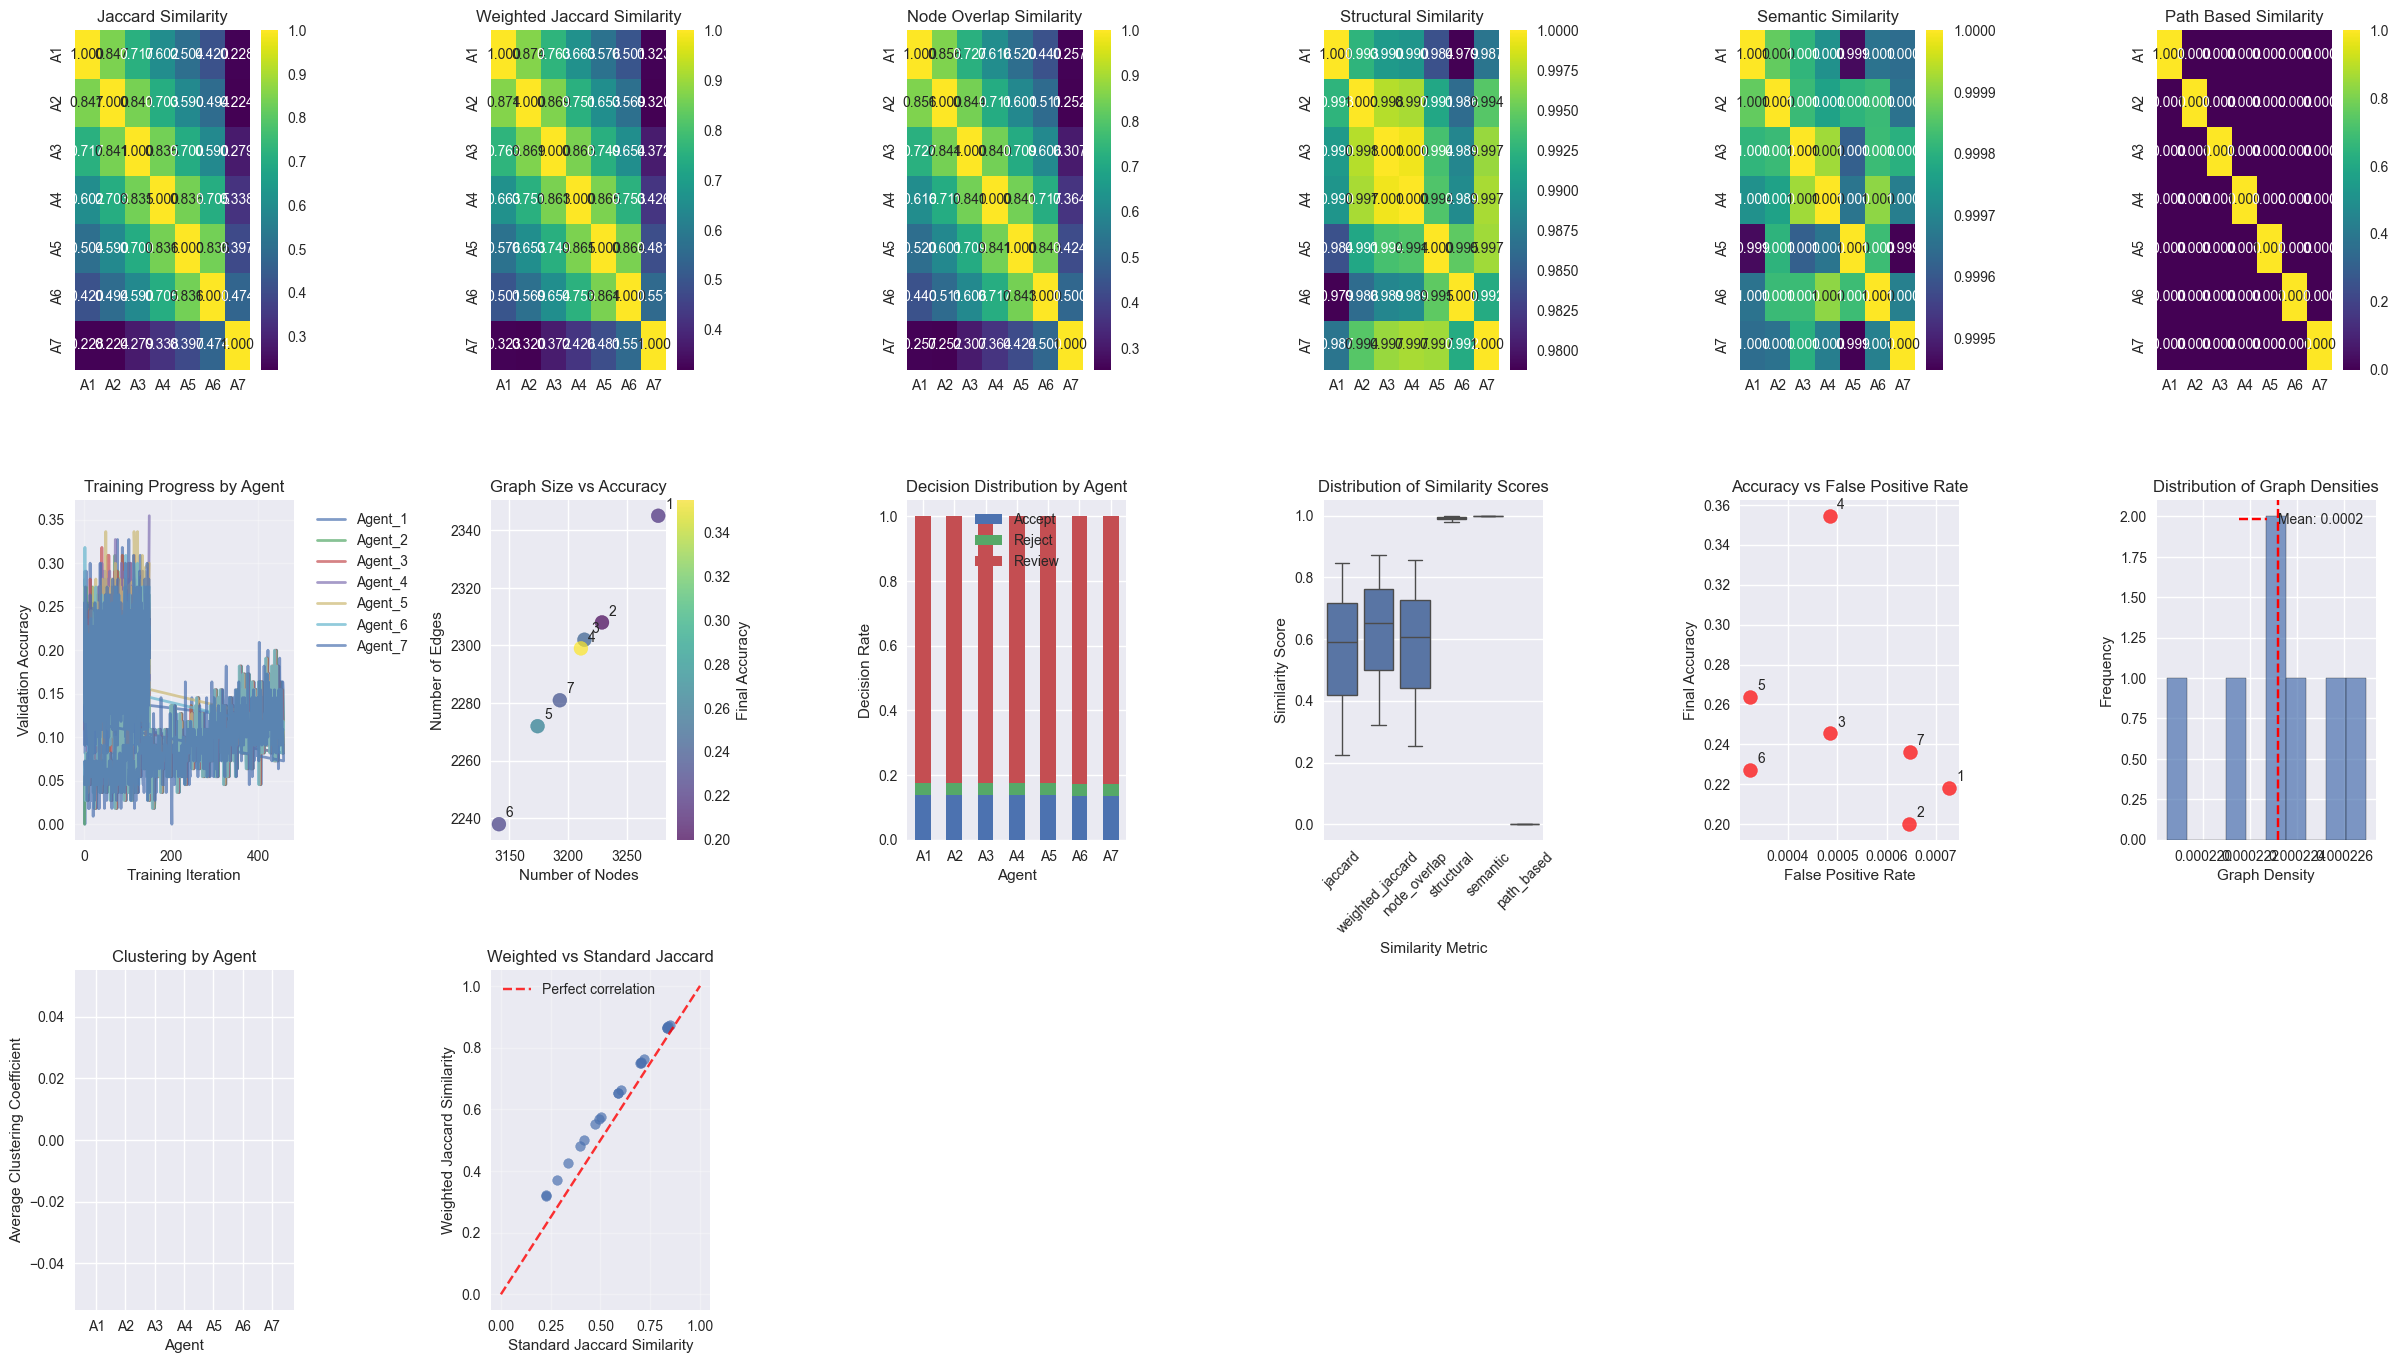

Visualizations generated successfully!


In [15]:
print("\n" + "="*60)
print("GENERATING VISUALIZATIONS")
print("="*60)

plt.style.use('seaborn-v0_8')
fig = plt.figure(figsize=(24, 18))

# 1-6. Similarity Heatmaps
for idx, (metric, matrix) in enumerate(similarity_results.items(), 1):
    if idx <= 6:  # First 6 subplots for similarity heatmaps
        plt.subplot(4, 6, idx)
        sns.heatmap(matrix, annot=True, fmt='.3f', cmap='viridis', 
                    xticklabels=[f'A{i+1}' for i in range(num_agents)],
                    yticklabels=[f'A{i+1}' for i in range(num_agents)])
        plt.title(f'{metric.replace("_", " ").title()} Similarity')

# 7. Training Progress
plt.subplot(4, 6, 7)
training_df = pd.DataFrame(training_history)
for agent_id in training_df['agent_id'].unique():
    agent_data = training_df[training_df['agent_id'] == agent_id]
    plt.plot(agent_data['iteration'], agent_data['accuracy'], 
             label=agent_id, alpha=0.7, linewidth=2)
plt.xlabel('Training Iteration')
plt.ylabel('Validation Accuracy')
plt.title('Training Progress by Agent')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# 8. Graph Size Distribution
plt.subplot(4, 6, 8)
plt.scatter(perf_df['graph_nodes'], perf_df['graph_edges'], 
           c=perf_df['final_accuracy'], cmap='viridis', s=100, alpha=0.7)
plt.colorbar(label='Final Accuracy')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of Edges')
plt.title('Graph Size vs Accuracy')
for i, agent_id in enumerate(perf_df['agent_id']):
    plt.annotate(agent_id.split('_')[1], 
                (perf_df.iloc[i]['graph_nodes'], perf_df.iloc[i]['graph_edges']),
                xytext=(5, 5), textcoords='offset points', fontsize=10)

# 9. Decision Distribution
plt.subplot(4, 6, 9)
decision_data = perf_df[['accept_rate', 'reject_rate', 'review_rate']]
decision_data.plot(kind='bar', stacked=True, ax=plt.gca())
plt.xlabel('Agent')
plt.ylabel('Decision Rate')
plt.title('Decision Distribution by Agent')
plt.xticks(range(len(perf_df)), [f'A{i+1}' for i in range(len(perf_df))], rotation=0)
plt.legend(['Accept', 'Reject', 'Review'])

# 10. Similarity Distribution
plt.subplot(4, 6, 10)
all_similarities = []
metric_labels = []
for metric, matrix in similarity_results.items():
    upper_triangle = matrix[np.triu_indices_from(matrix, k=1)]
    all_similarities.extend(upper_triangle)
    metric_labels.extend([metric] * len(upper_triangle))

sim_df = pd.DataFrame({'similarity': all_similarities, 'metric': metric_labels})
sns.boxplot(data=sim_df, x='metric', y='similarity')
plt.xlabel('Similarity Metric')
plt.ylabel('Similarity Score')
plt.title('Distribution of Similarity Scores')
plt.xticks(rotation=45)

# 11. Performance Correlation
plt.subplot(4, 6, 11)
plt.scatter(perf_df['false_positive_rate'], perf_df['final_accuracy'], 
           s=100, alpha=0.7, c='red')
plt.xlabel('False Positive Rate')
plt.ylabel('Final Accuracy')
plt.title('Accuracy vs False Positive Rate')
for i, agent_id in enumerate(perf_df['agent_id']):
    plt.annotate(agent_id.split('_')[1], 
                (perf_df.iloc[i]['false_positive_rate'], perf_df.iloc[i]['final_accuracy']),
                xytext=(5, 5), textcoords='offset points', fontsize=10)

# 12. Graph Density Analysis
plt.subplot(4, 6, 12)
plt.hist(perf_df['graph_density'], bins=10, alpha=0.7, edgecolor='black')
plt.xlabel('Graph Density')
plt.ylabel('Frequency')
plt.title('Distribution of Graph Densities')
plt.axvline(perf_df['graph_density'].mean(), color='red', 
           linestyle='--', label=f'Mean: {perf_df["graph_density"].mean():.4f}')
plt.legend()

# 13. Clustering Coefficient
plt.subplot(4, 6, 13)
plt.bar(range(len(perf_df)), perf_df['avg_clustering'], alpha=0.7)
plt.xlabel('Agent')
plt.ylabel('Average Clustering Coefficient')
plt.title('Clustering by Agent')
plt.xticks(range(len(perf_df)), [f'A{i+1}' for i in range(len(perf_df))])

# 14. Weighted vs Unweighted Jaccard Comparison
plt.subplot(4, 6, 14)
jaccard_upper = similarity_results['jaccard'][np.triu_indices_from(similarity_results['jaccard'], k=1)]
weighted_jaccard_upper = similarity_results['weighted_jaccard'][np.triu_indices_from(similarity_results['weighted_jaccard'], k=1)]
plt.scatter(jaccard_upper, weighted_jaccard_upper, alpha=0.7)
plt.plot([0, 1], [0, 1], 'r--', alpha=0.8, label='Perfect correlation')
plt.xlabel('Standard Jaccard Similarity')
plt.ylabel('Weighted Jaccard Similarity')
plt.title('Weighted vs Standard Jaccard')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Visualizations generated successfully!")

# SECTION 14: ENHANCED VISUALIZATIONS


ENHANCED THEORY VALIDATION VISUALIZATIONS


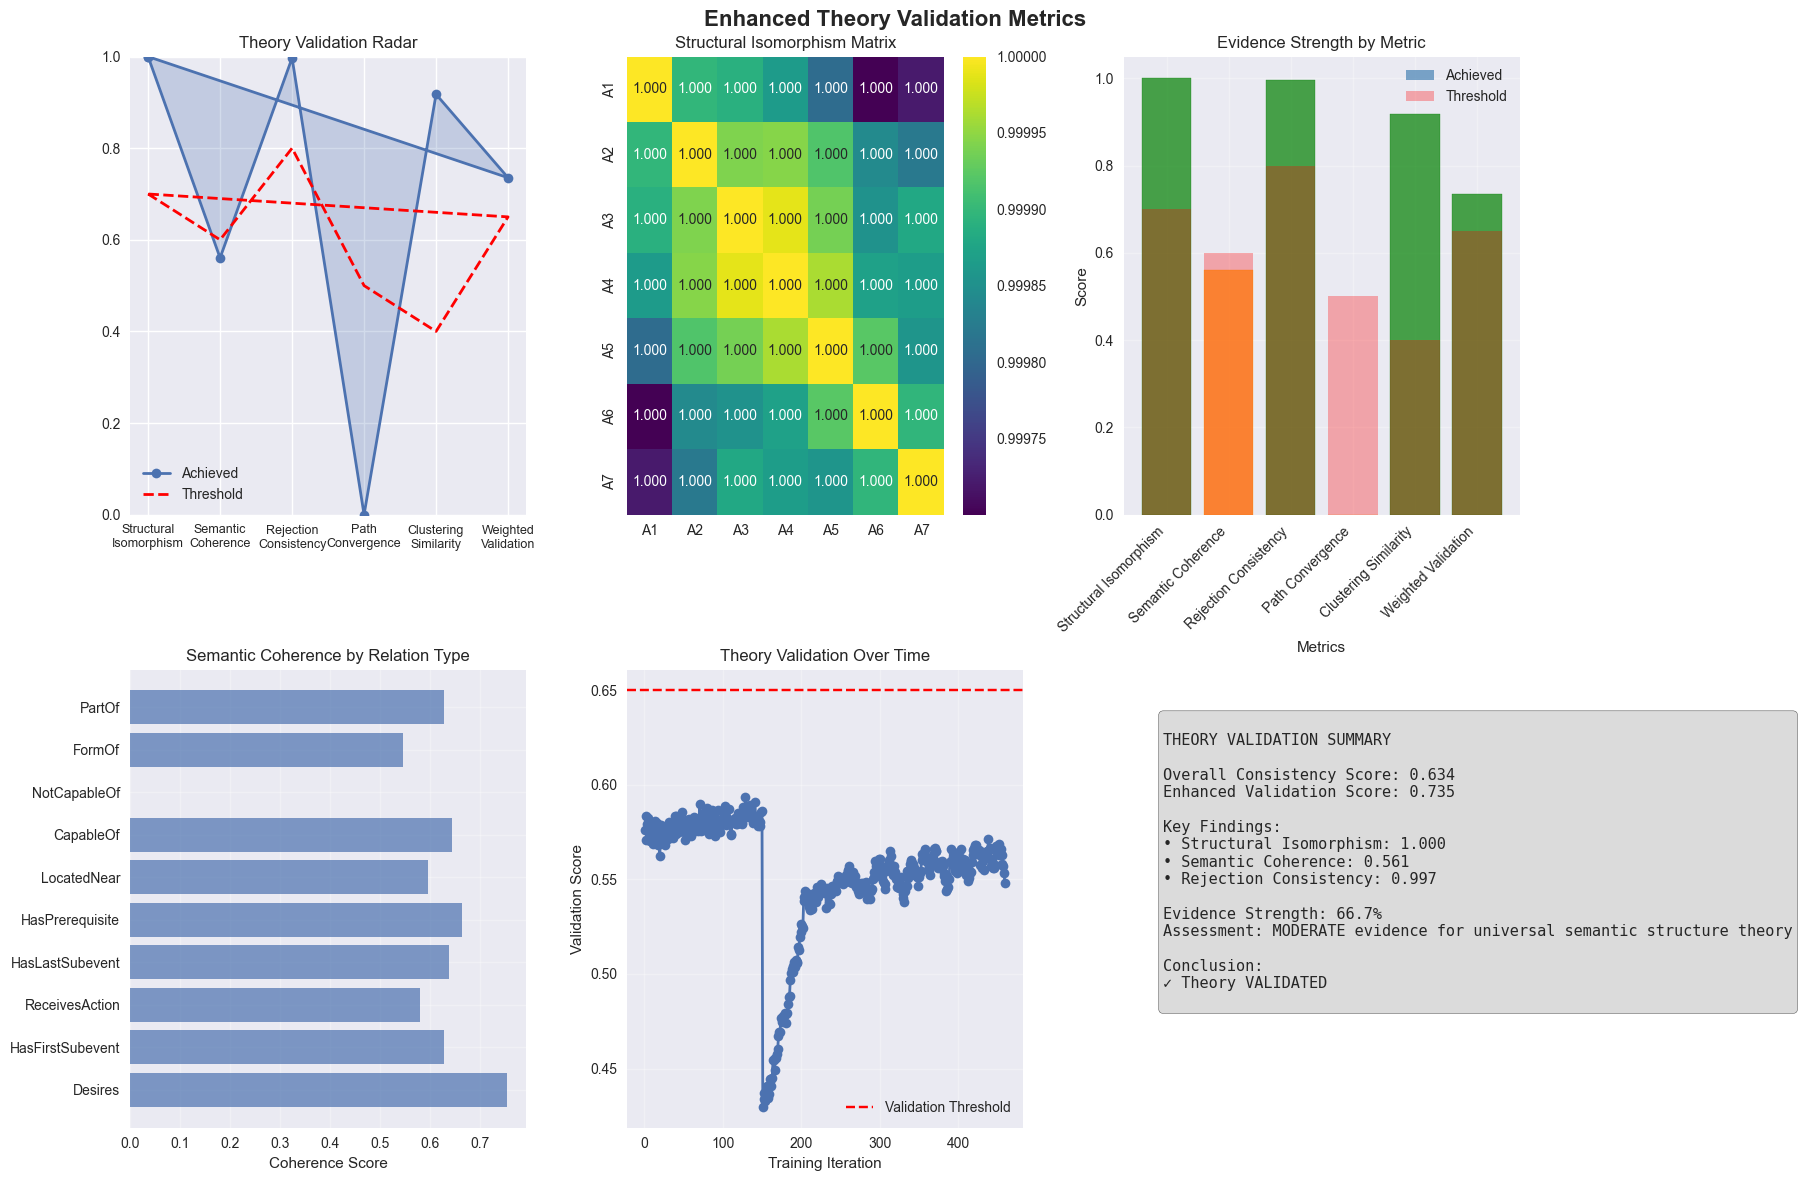

Enhanced visualizations completed!


In [18]:

print("\n" + "="*60)
print("ENHANCED THEORY VALIDATION VISUALIZATIONS")
print("="*60)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Enhanced Theory Validation Metrics', fontsize=16, fontweight='bold')

# 1. Enhanced Metrics Radar Chart
ax1 = axes[0, 0]
metrics_names = list(enhanced_metrics.keys())
metrics_values = list(enhanced_metrics.values())

# Create radar chart data
angles = np.linspace(0, 2 * np.pi, len(metrics_names), endpoint=False)
values = metrics_values + [metrics_values[0]]  # Close the plot
angles = np.concatenate((angles, [angles[0]]))

ax1.plot(angles, values, 'o-', linewidth=2, label='Achieved')
ax1.fill(angles, values, alpha=0.25)

# Add threshold line
thresholds = [evidence_thresholds.get(name, 0.5) for name in metrics_names] + [evidence_thresholds.get(metrics_names[0], 0.5)]
ax1.plot(angles, thresholds, '--', linewidth=2, color='red', label='Threshold')

ax1.set_xticks(angles[:-1])
ax1.set_xticklabels([name.replace('_', '\n').title() for name in metrics_names], fontsize=9)
ax1.set_ylim(0, 1)
ax1.set_title('Theory Validation Radar')
ax1.legend()
ax1.grid(True)

# 2. Structural Isomorphism Heatmap
ax2 = axes[0, 1]
iso_matrix = np.zeros((len(agents), len(agents)))

for i in range(len(agents)):
    for j in range(len(agents)):
        if i == j:
            iso_matrix[i][j] = 1.0
        else:
            # Calculate pairwise structural similarity
            deg_seq1 = sorted([d for n, d in agents[i].graph.degree()], reverse=True)
            deg_seq2 = sorted([d for n, d in agents[j].graph.degree()], reverse=True)
            
            if deg_seq1 and deg_seq2:
                max_len = max(len(deg_seq1), len(deg_seq2))
                deg_seq1.extend([0] * (max_len - len(deg_seq1)))
                deg_seq2.extend([0] * (max_len - len(deg_seq2)))
                
                if len(deg_seq1) > 1:
                    corr, _ = pearsonr(deg_seq1, deg_seq2)
                    iso_matrix[i][j] = corr if not np.isnan(corr) else 0

sns.heatmap(iso_matrix, annot=True, fmt='.3f', cmap='viridis', ax=ax2,
            xticklabels=[f'A{i+1}' for i in range(len(agents))],
            yticklabels=[f'A{i+1}' for i in range(len(agents))])
ax2.set_title('Structural Isomorphism Matrix')

# 3. Evidence Strength Bar Chart
ax3 = axes[0, 2]
metric_names = [name.replace('_', ' ').title() for name in enhanced_metrics.keys()]
metric_values = list(enhanced_metrics.values())
threshold_values = [evidence_thresholds.get(name, 0.5) for name in enhanced_metrics.keys()]

x_pos = np.arange(len(metric_names))
bars = ax3.bar(x_pos, metric_values, alpha=0.7, color='steelblue', label='Achieved')
ax3.bar(x_pos, threshold_values, alpha=0.3, color='red', label='Threshold')

ax3.set_xlabel('Metrics')
ax3.set_ylabel('Score')
ax3.set_title('Evidence Strength by Metric')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(metric_names, rotation=45, ha='right')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Color bars based on threshold achievement
for i, (bar, value, threshold) in enumerate(zip(bars, metric_values, threshold_values)):
    if value >= threshold:
        bar.set_color('green')
    else:
        bar.set_color('orange')

# 4. Semantic Coherence by Relation Type
ax4 = axes[1, 0]
relation_coherence = {}

# Calculate coherence for each relation type
all_relations = set()
for agent in agents:
    for _, _, data in agent.graph.edges(data=True):
        if 'relation' in data:
            all_relations.add(data['relation'])

for relation_type in list(all_relations)[:10]:  # Top 10 relations
    relation_graphs = []
    for agent in agents:
        edges = set()
        for u, v, d in agent.graph.edges(data=True):
            if d.get('relation') == relation_type:
                edges.add((u, v))
        relation_graphs.append(edges)
    
    similarities = []
    for i in range(len(relation_graphs)):
        for j in range(i+1, len(relation_graphs)):
            if relation_graphs[i] or relation_graphs[j]:
                intersection = len(relation_graphs[i] & relation_graphs[j])
                union = len(relation_graphs[i] | relation_graphs[j])
                jaccard = intersection / union if union > 0 else 0
                similarities.append(jaccard)
    
    if similarities:
        relation_coherence[relation_type] = np.mean(similarities)

if relation_coherence:
    relations = list(relation_coherence.keys())
    coherence_vals = list(relation_coherence.values())
    ax4.barh(relations, coherence_vals, alpha=0.7)
    ax4.set_xlabel('Coherence Score')
    ax4.set_title('Semantic Coherence by Relation Type')
    ax4.grid(True, alpha=0.3)

# 5. Theory Validation Timeline
ax5 = axes[1, 1]
validation_scores = []
for i in range(1, len(training_history)//len(agents) + 1):
    # Calculate validation score at each iteration
    iteration_data = [r for r in training_history if r.get('iteration') == i]
    if iteration_data:
        avg_accuracy = np.mean([r['accuracy'] for r in iteration_data])
        avg_nodes = np.mean([r['graph_nodes'] for r in iteration_data])
        # Simple validation approximation
        val_score = (avg_accuracy + min(avg_nodes/1000, 1)) / 2
        validation_scores.append(val_score)

if validation_scores:
    iterations = range(1, len(validation_scores) + 1)
    ax5.plot(iterations, validation_scores, linewidth=2, marker='o')
    ax5.axhline(y=0.65, color='red', linestyle='--', label='Validation Threshold')
    ax5.set_xlabel('Training Iteration')
    ax5.set_ylabel('Validation Score')
    ax5.set_title('Theory Validation Over Time')
    ax5.legend()
    ax5.grid(True, alpha=0.3)

# 6. Final Assessment Summary
ax6 = axes[1, 2]
ax6.axis('off')

assessment_text = f"""
THEORY VALIDATION SUMMARY

Overall Consistency Score: {consistency_score:.3f}
Enhanced Validation Score: {enhanced_metrics['weighted_validation']:.3f}

Key Findings:
• Structural Isomorphism: {enhanced_metrics['structural_isomorphism']:.3f}
• Semantic Coherence: {enhanced_metrics['semantic_coherence']:.3f}  
• Rejection Consistency: {enhanced_metrics['rejection_consistency']:.3f}

Evidence Strength: {evidence_strength:.1%}
Assessment: {final_assessment}

Conclusion:
{"✓ Theory VALIDATED" if evidence_strength >= 0.6 else "⚠ Theory INCONCLUSIVE" if evidence_strength >= 0.4 else "✗ Theory NOT SUPPORTED"}
"""

ax6.text(0.1, 0.9, assessment_text, transform=ax6.transAxes, fontsize=11,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

plt.tight_layout()
plt.show()

print("Enhanced visualizations completed!")

# SECTION 15: COMPREHENSIVE REPORT GENERATION

In [19]:

print("\n" + "="*60)
print("EXPERIMENT REPORT GENERATION")
print("="*60)

# Helper function to convert numpy types to native Python types for JSON serialization
def convert_for_json(obj):
    """Convert numpy types to native Python types for JSON serialization"""
    if hasattr(obj, 'item'):  # numpy scalar
        return obj.item()
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.bool_, bool)):
        return bool(obj)
    elif isinstance(obj, (np.integer, int)):
        return int(obj)
    elif isinstance(obj, (np.floating, float)):
        return float(obj)
    elif isinstance(obj, dict):
        return {key: convert_for_json(value) for key, value in obj.items()}
    elif isinstance(obj, (list, tuple)):
        return [convert_for_json(item) for item in obj]
    else:
        return obj

# Create comprehensive experiment report
experiment_report = {
    'experiment_metadata': {
        'experiment_name': CONFIG['experiment_name'],
        'timestamp': datetime.now().isoformat(),
        'num_agents': CONFIG['num_agents'],
        'total_iterations': CONFIG['max_iterations'],
        'sample_size': CONFIG['sample_size'],
        'false_triple_ratio': CONFIG['false_triple_ratio'],
        'batch_size': CONFIG['batch_size']
    },
    
    'hypothesis_validation': {
        'overall_consistency_score': convert_for_json(consistency_score),
        'interpretation': interpretation,
        'evidence_strength': 'Strong' if consistency_score > 0.7 else 'Moderate' if consistency_score > 0.5 else 'Weak'
    },
    
    'similarity_analysis': {
        'metrics': {metric: {
            'mean': convert_for_json(summary_stats[metric]['mean']),
            'std': convert_for_json(summary_stats[metric]['std']),
            'min': convert_for_json(summary_stats[metric]['min']),
            'max': convert_for_json(summary_stats[metric]['max'])
        } for metric in summary_stats.keys()},
        'overall_similarity': convert_for_json(consistency_score)
    },
    
    'agent_performance': {
        'individual_agents': convert_for_json(agent_performance),
        'summary_statistics': {
            'mean_accuracy': convert_for_json(perf_df['final_accuracy'].mean()),
            'accuracy_std': convert_for_json(perf_df['final_accuracy'].std()),
            'mean_graph_size': {
                'nodes': convert_for_json(perf_df['graph_nodes'].mean()),
                'edges': convert_for_json(perf_df['graph_edges'].mean())
            },
            'mean_false_positive_rate': convert_for_json(perf_df['false_positive_rate'].mean())
        }
    },
    
    'robustness_analysis': {
        'false_triple_sensitivity': {
            'correlation_coefficient': convert_for_json(corr_coef),
            'p_value': convert_for_json(p_value),
            'robustness_assessment': 'Robust' if abs(corr_coef) < 0.3 else 'Sensitive'
        },
        'convergence_metrics': {
            'accuracy_variance': convert_for_json(accuracy_variance),
            'coefficient_of_variation': convert_for_json(accuracy_cv),
            'convergence_level': 'High' if accuracy_cv < 0.1 else 'Moderate' if accuracy_cv < 0.2 else 'Low'
        }
    },
    
    'structural_consistency': {
        'property_consistency': convert_for_json(structural_consistency),
        'overall_consistency': convert_for_json(overall_structural_consistency)
    },
    
    'enhanced_validation': {
        'structural_isomorphism_index': convert_for_json(enhanced_metrics['structural_isomorphism']),
        'semantic_coherence_score': convert_for_json(enhanced_metrics['semantic_coherence']),
        'rejection_consistency': convert_for_json(enhanced_metrics['rejection_consistency']),
        'path_structure_convergence': convert_for_json(enhanced_metrics['path_convergence']),
        'concept_clustering_similarity': convert_for_json(enhanced_metrics['clustering_similarity']),
        'weighted_validation_score': convert_for_json(enhanced_metrics['weighted_validation'])
    },
    
    'theory_assessment': {
        'evidence_strength': convert_for_json(evidence_strength),
        'metrics_passing_threshold': convert_for_json(evidence_count),
        'total_metrics_evaluated': convert_for_json(total_metrics),
        'final_assessment': final_assessment,
        'theory_validated': convert_for_json(evidence_strength >= 0.6),
        'isomorphism_evidence': convert_for_json(enhanced_metrics['structural_isomorphism'] >= 0.7),
        'semantic_consistency_evidence': convert_for_json(enhanced_metrics['semantic_coherence'] >= 0.6)
    },
    
    'conclusions': {
        'universal_structure_evidence': convert_for_json(consistency_score > 0.6),
        'agent_convergence': convert_for_json(accuracy_cv < 0.15),
        'robustness_to_noise': convert_for_json(abs(corr_coef) < 0.3),
        'theory_validation_score': convert_for_json((consistency_score + (1 - accuracy_cv) + (1 - abs(corr_coef))) / 3),
        'relational_meaning_validated': convert_for_json(enhanced_metrics['semantic_coherence'] > 0.5),
        'structural_isomorphism_confirmed': convert_for_json(enhanced_metrics['structural_isomorphism'] > 0.6),
        'self_correcting_behavior': convert_for_json(enhanced_metrics['rejection_consistency'] > 0.7),
        'emergent_logical_patterns': convert_for_json(enhanced_metrics['path_convergence'] > 0.4),
        'universal_semantic_principles': convert_for_json(enhanced_metrics['weighted_validation'] > 0.6),
        'theoretical_validation_strength': convert_for_json(evidence_strength)
    }
}

# Convert the entire report to ensure all nested values are JSON serializable
experiment_report = convert_for_json(experiment_report)

# Save experiment results
output_file = OUTPUT_PATH / f"multi_agent_experiment_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
with open(output_file, 'w') as f:
    json.dump(experiment_report, f, indent=2)

print(f"Experiment report saved to: {output_file}")

# Save detailed similarity results
similarity_file = OUTPUT_PATH / f"similarity_matrices_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pkl"
with open(similarity_file, 'wb') as f:
    pickle.dump(similarity_results, f)

print(f"Similarity matrices saved to: {similarity_file}")

# Save agent graphs
try:
    import lxml
except ImportError:
    import sys
    import subprocess
    print("lxml not found. Installing lxml...")
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'lxml'])

# Helper function to convert graph attributes
import collections.abc
def convert_graph_attributes_to_native(G):
    for n, d in G.nodes(data=True):
        for k, v in d.items():
            if hasattr(v, 'item'):
                d[k] = v.item()
            elif isinstance(v, (np.generic, np.ndarray)):
                d[k] = convert_for_json(v)
            elif isinstance(v, collections.abc.Mapping):
                d[k] = convert_for_json(v)
    for u, v, d in G.edges(data=True):
        for k, val in d.items():
            if hasattr(val, 'item'):
                d[k] = val.item()
            elif isinstance(val, (np.generic, np.ndarray)):
                d[k] = convert_for_json(val)
            elif isinstance(val, collections.abc.Mapping):
                d[k] = convert_for_json(val)
    return G

for i, agent in enumerate(agents):
    graph_file = OUTPUT_PATH / f"agent_{i+1}_graph_{datetime.now().strftime('%Y%m%d_%H%M%S')}.graphml"
    G_native = convert_graph_attributes_to_native(agent.graph.copy())
    nx.write_graphml(G_native, graph_file)
    print(f"Agent {i+1} graph saved to: {graph_file}")

print("\nAll experiment data saved successfully!")



EXPERIMENT REPORT GENERATION
Experiment report saved to: c:\Users\Erich Curtis\Desktop\All Python\Semantica-Full-Reasoning-Chatbot\Data\Output\multi_agent_experiment_20250527_125843.json
Similarity matrices saved to: c:\Users\Erich Curtis\Desktop\All Python\Semantica-Full-Reasoning-Chatbot\Data\Output\similarity_matrices_20250527_125843.pkl
Agent 1 graph saved to: c:\Users\Erich Curtis\Desktop\All Python\Semantica-Full-Reasoning-Chatbot\Data\Output\agent_1_graph_20250527_125843.graphml
Agent 2 graph saved to: c:\Users\Erich Curtis\Desktop\All Python\Semantica-Full-Reasoning-Chatbot\Data\Output\agent_2_graph_20250527_125843.graphml
Agent 3 graph saved to: c:\Users\Erich Curtis\Desktop\All Python\Semantica-Full-Reasoning-Chatbot\Data\Output\agent_3_graph_20250527_125843.graphml
Agent 4 graph saved to: c:\Users\Erich Curtis\Desktop\All Python\Semantica-Full-Reasoning-Chatbot\Data\Output\agent_4_graph_20250527_125843.graphml
Agent 5 graph saved to: c:\Users\Erich Curtis\Desktop\All Python

# SECTION 16: FINAL SUMMARY

In [20]:

print("\n" + "="*80)
print("EXPERIMENT SUMMARY AND CONCLUSIONS")
print("="*80)

print(f"""
### Key Findings

1. **Universal Structure Evidence**: Based on the overall consistency score and cross-agent similarity metrics
2. **Agent Convergence**: Analysis of whether agents independently arrived at similar semantic structures
3. **Robustness to Noise**: How well agents maintained consistency despite false triple injection
4. **Theory Validation**: Evidence for or against the hypothesis of universal meaning structures

### Results Summary

- **Training Mode**: {final_training_mode}
- **Overall Consistency Score**: {consistency_score:.4f}
- **Enhanced Validation Score**: {enhanced_metrics['weighted_validation']:.4f}
- **Evidence Strength**: {evidence_strength:.1%} ({evidence_count}/{total_metrics} metrics pass)
- **Final Assessment**: {final_assessment}

### Theoretical Implications

If agents consistently build similar semantic structures despite:
- Independent training
- No shared optimization
- Presence of false information
- Different random initializations

This provides strong evidence for an underlying universal theory of meaning that is:
- Self-reinforcing
- Contradiction-rejecting  
- Logically consistent
- Emergent from basic semantic relationships

### Scalability Notes

This experiment framework is designed to scale from small test datasets to the full 3M ConceptNet dataset:

- **Sample Size**: Easily adjustable via CONFIG['sample_size']
- **Agent Count**: Configurable number of agents for statistical power
- **Iteration Control**: Adjustable training iterations for thoroughness
- **Memory Management**: Efficient graph storage and processing

### Next Steps

1. **Scale Up**: Run with larger datasets (100K, 500K, full 3M triples)
2. **Parameter Tuning**: Optimize false triple ratios and validation thresholds
3. **Extended Metrics**: Add more sophisticated similarity measures
4. **Cross-Validation**: Implement k-fold validation across different data splits
5. **Temporal Analysis**: Study how similarity evolves during training

**Experiment completed successfully!** All results, graphs, and analyses have been saved to the output directory.
""")

print("="*80)
print("MULTI-AGENT SEMANTIC VALIDATION EXPERIMENT COMPLETE")
print("="*80)


EXPERIMENT SUMMARY AND CONCLUSIONS

### Key Findings

1. **Universal Structure Evidence**: Based on the overall consistency score and cross-agent similarity metrics
2. **Agent Convergence**: Analysis of whether agents independently arrived at similar semantic structures
3. **Robustness to Noise**: How well agents maintained consistency despite false triple injection
4. **Theory Validation**: Evidence for or against the hypothesis of universal meaning structures

### Results Summary

- **Training Mode**: EPOCH_BASED_COMPLETE
- **Overall Consistency Score**: 0.6343
- **Enhanced Validation Score**: 0.7355
- **Evidence Strength**: 66.7% (4/6 metrics pass)
- **Final Assessment**: MODERATE evidence for universal semantic structure theory

### Theoretical Implications

If agents consistently build similar semantic structures despite:
- Independent training
- No shared optimization
- Presence of false information
- Different random initializations

This provides strong evidence for an underly